In [1]:
# EMPeaksをインポートする
import sys 
sys.path.append("C:/Users/nauli/AnacondaProjects/20230127EMPeaks") # pathは自分の環境のものを指定

In [2]:
%matplotlib inline
from EMPeaks import GaussianMixture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

#ある値に近いピークの検索のため、リストから最近接値を探す関数
def getNearestValue(list, num):
    # リスト要素と対象値の差分を計算し最小値のインデックスを取得
    idx = np.abs(np.asarray(list) - num).argmin()
    return idx

#エネルギーの値を昇順にsortし、エネルギーの値(DataFrameの0列目)がmin<x<maxの行を抽出する関数
def sort_trimming(df, min, max):
    #エネルギーの値(DataFrameの0列目)がmin<x<maxの行を抽出(trimming)
    trimmed_dataframe = df[(df[0] > min) & (df[0] < max)]
    #エネルギーの値を昇順にsort
    trimmed_sorted_dataframe = trimmed_dataframe.sort_values(0)
    return trimmed_sorted_dataframe
    
# データをいくつか抽出して見る関数　均等分割でn_plt個のスペクトルを表示
def data_skimming(df, n_plt):
    d=(len(df.columns.to_numpy())-1) // int(n_plt-1)
    l = [1]
    k = 0
    for i in range(int(n_plt-1)):
        k += d
        l.append(k)
    for i in l:
        x = df[0]
        y = df[i]
        fig, ax = plt.subplots(facecolor="w")
        fig.suptitle("No."+str(i))
        plt.scatter(x,y)
    return None

# 1本だけデータを取り出してフィットを行う関数 この関数を使ってパラメータを調整する
def EMPeaks_gmm_fit_test(df, column_index, energy_range_min, energy_range_max, number_of_peaks, BG="none", trial_times=3, convergence_value=2e-8):
    x = df[0].values
    y = df[column_index].values
    gmm = GaussianMixture.GaussianMixtureModel(K=number_of_peaks, background=BG, x_min=energy_range_min, x_max=energy_range_max)
    gmm.sampling(x,y,trial=trial_times, r_eps=convergence_value)
    gmm.plot(x,y)
    gmm_height = [gmm.N[i]/(np.sqrt(2*np.pi)*gmm.sigma[i]) for i in range(number_of_peaks)]
    test_result_df = pd.DataFrame([gmm.mu[:number_of_peaks], gmm.sigma[:number_of_peaks], gmm.N[:number_of_peaks], gmm_height,gmm.pi[:number_of_peaks]],index=["mu", "sigma", "N", "height","pi"])
    return test_result_df 

# 全データをフィットする
def EMPeaks_gmm_fit_all(df, energy_range_min, energy_range_max, number_of_peaks, peak_position, BG="none", trial_times=3, convergence_value=2e-8, plot_set=False):
    N_points = len(df.columns.values)
    # アウトプットのためのデータフレームの作成
    index_name = []
    for i in range(number_of_peaks):
        index_name += ["model_"+str(i)+str(j) for j in ["_mu", "_sigma", "_N", "_height", "_pi"]]
    index_name += ["nearest_mu", "highest_mu", "minsigma_mu", "maxpi_mu"]
    result_output_df = pd.DataFrame(index=index_name, columns=[])
    # i番目のデータについて解析していく
    for i in range(1,N_points):
        x = df[0].values
        y = df[i].values
        gmm = GaussianMixture.GaussianMixtureModel(K=number_of_peaks, background=BG, x_min=energy_range_min, x_max=energy_range_max)
        gmm.sampling(x,y,trial=trial_times, r_eps=convergence_value)
        if plot_set == True:
            gmm.plot(x,y)
        # heightの計算
        gmm_height = [gmm.N[n]/(np.sqrt(2*np.pi)*gmm.sigma[n]) for n in range(number_of_peaks)]
        # 各測定点のデータを1列の配列にする
        result_list =[]
        for j in range(number_of_peaks):
            result_list += [gmm.mu[j], gmm.sigma[j], gmm.N[j], gmm_height[j], gmm.pi[j]]
        # nearest, highest
        result_list += [gmm.mu[getNearestValue(gmm.mu[:number_of_peaks], peak_position)], gmm.mu[np.array(gmm_height[:number_of_peaks]).argmax()], gmm.mu[np.array(gmm.sigma[:number_of_peaks]).argmin()], gmm.mu[np.array(gmm.pi[:number_of_peaks]).argmax()]]
        result_output_df[i] = result_list
        print(i)
    return result_output_df

# 全データフィットした結果をcsvファイルで出力する関数
def data_save(result_output_df,file_path):
    path_list = os.path.split(file_path)
    result_output_df.to_csv(path_list[0]+"\\Fitted_"+path_list[1][:-4]+".csv")

def heatmapping(result_output_df, plotdata, shape_x, shape_z, color_min, color_max, color_type="seismic"):
    # line_scanの場合とmappingの場合で分ける
    #X方向のline_scanについては未実装
    if shape_z == 1:
        # 作成したいサイズにreshape
        array = np.array(result_output_df.loc[plotdata]).reshape(shape_x)
        # line_scanでは1列ではつぶれて見えない場合が多いので，同じ行を複製して正方形にする
        reshaped_array = np.repeat(array[None, :], shape_x, axis=0)
    else:
        reshaped_array = np.array(result_output_df.loc[plotdata]).reshape(shape_x, shape_z)
    #nanoESCAでは右下原点，heatmapでは左上が原点なので，.T で行列を転置し，flipでXY軸を反転させてnano_ESCA像と合わせる
    flip_array = np.flip(reshaped_array.T)
    #heatmap出力
    plt.figure()
    plt.imshow(flip_array, interpolation='nearest',vmin= color_min, vmax=color_max, cmap=color_type)
    plt.colorbar()
    plt.show()
    return None

# フィット結果のガウシアンを再構成するための関数
def gaussian_reconstructer(x, re_mu, re_sigma, re_N):
    z = np.sqrt(2.0 * np.pi * re_sigma**2)
    x_p = (x - re_mu) / (np.sqrt(2.0) * re_sigma)
    return re_N * np.exp(-x_p**2) / z

# フィット結果のプロットを再構成するための関数
def plot_reconstracter(df, export_df, column_number_re):
    # model_parametersがそれぞれ入った辞書を作成
    model_dict = {}
    for a in range(number_of_peaks):
        tmp_list = [export_df.iat[c+5*a, column_number_re-1] for c in range(5)]
        # tmp_key = "model_" + str(a)
        tmp_dict = {a: tmp_list}
        model_dict.update(tmp_dict)
    # model_dictの中身は、key:モデル番号、value:["mu", "sigma", "N", "height", "pi"]
    
    x = df[0]
    y = df[column_number_re]
    figsize = (8, 3)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    
    for model_n in model_dict:
        re_mu, re_sigma, re_N = model_dict[model_n][0], model_dict[model_n][1], model_dict[model_n][2]
        ax.plot(x, gaussian_reconstructer(x, re_mu, re_sigma, re_N), linewidth=3, label='model_' + str(model_n))
    ax.plot(x, np.sum([gaussian_reconstructer(x, model_dict[n][0], model_dict[n][1], model_dict[n][2]) for n in model_dict], axis=0), 'black', linewidth=3, ls='--', label='full_model')
    ax.scatter(x, y, label='data')
    ax.set_xlabel('Energy [eV]')
    ax.set_ylabel('Intensity')
    ax.legend()
    plt.show()


In [3]:
'''
入力項目
'''
file_path = r'C:/Users/nauli/AnacondaProjects/20230127EMPeaks/C1sMapping181214065217.txt' #データのpath
energy_range_max = 571 #解析したいエネルギー領域
energy_range_min = 549

In [4]:
# データの読み込みとトリミング
raw_df = pd.read_csv(file_path, header=None,sep="\t")
df = sort_trimming(raw_df.T, energy_range_min, energy_range_max)

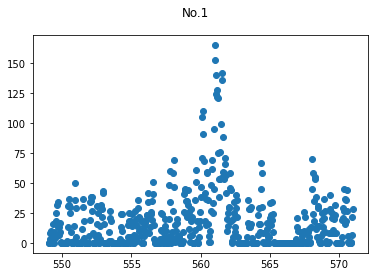

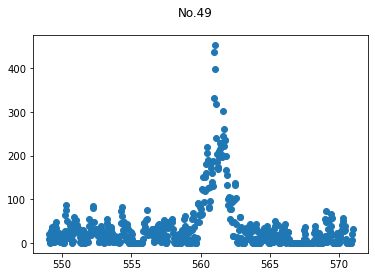

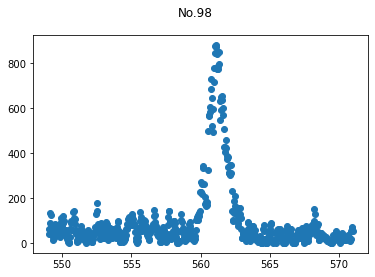

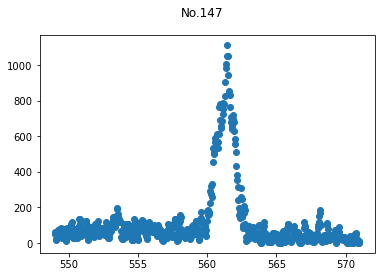

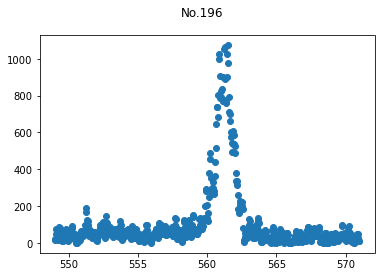

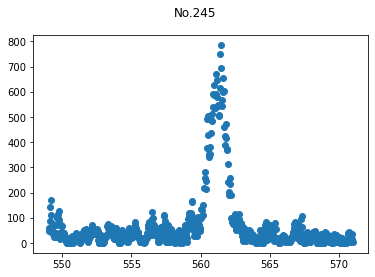

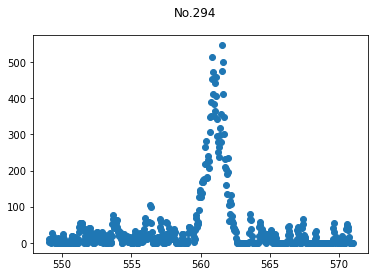

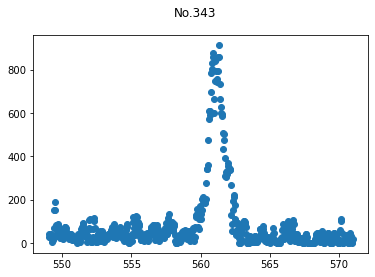

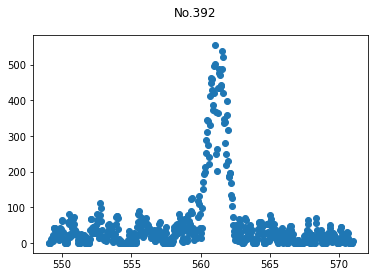

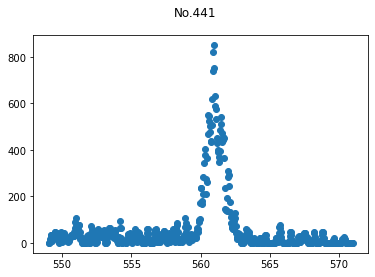

In [5]:
# データのざっと見
data_skimming(df,10)

In [6]:
'''
入力項目
'''
column_index=195 #testに使用するデータの選択(n番目のデータ), 例えば上の10本のスペクトルのうちNo.196のスペクトルでテストしたい場合は196-1で195とうちこむ。
number_of_peaks = 2 #ガウシアンの本数
peak_position = 561 #mu(nearest)を決める基準値, 上記例では1本だが、2本あるうちの片方に注目したい場合などに使う。
BG_a="none" #BG処理 "none" or "uniform" or "linear"
trial_times_a = 5 #1データあたりの試行回数
convergence_value_a = 2e-8 #収束の厳密性
# plot_set_a = False # 全データをフィッティングする時にplotするかどうか(注：Trueだとlogが長くなります)

* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.01 s
   LogLikelihood:     -1.40872946e+05
        residual:      1.07762530e-08
<< Optimizing normalization factor by using least square method. >>
init 2139.308000000003
   non-linear least-square optimization is successfully finished.
            RMSE:      4.340682e+01
    Elapsed time:      3.116131e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  20, elapsed time  0.01 s
   LogLikelihood:     -1.40872945e+05
        residual:      7.74869363e-09
<< Optimizing normalization factor by using least square method. >>
init 2139.308000000003
   non-linear least-square optimization is successfully finished.
            RMSE:      4.340677e+01
    Elapsed time:      3.007174e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  30, elapsed time  0.01 s


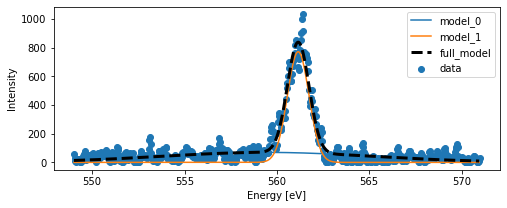

,0,1
mu,559.451914,561.154369
sigma,5.747172,0.584119
N,1002.330270,1129.136744
height,69.577157,771.179522
pi,0.470254,0.529746


In [8]:
# 1本だけデータを取り出してフィット　パラメータ調整用
EMPeaks_gmm_fit_test(df, column_index, energy_range_min, energy_range_max, number_of_peaks, BG=BG_a, trial_times=trial_times_a, convergence_value=convergence_value_a)

In [9]:
# 全データフィット
export_df = EMPeaks_gmm_fit_all(df, energy_range_min, energy_range_max, number_of_peaks, peak_position, BG=BG_a, trial_times=trial_times_a, convergence_value=convergence_value_a)
export_df

* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter. 328, elapsed time  0.13 s
   LogLikelihood:     -2.92313609e+04
        residual:      1.82781224e-08
<< Optimizing normalization factor by using least square method. >>
init 351.93600000000265
   non-linear least-square optimization is successfully finished.
            RMSE:      2.255713e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter. 976, elapsed time  0.43 s
   LogLikelihood:     -2.92313607e+04
        residual:      1.03810107e-08
<< Optimizing normalization factor by using least square method. >>
init 351.93600000000265
   non-linear least-square optimization is successfully finished.
            RMSE:      2.255711e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter. 267, elapsed time  0.13 

   non-linear least-square optimization is successfully finished.
            RMSE:      3.348285e+01
    Elapsed time:      1.562524e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  29, elapsed time  0.02 s
   LogLikelihood:     -4.11453390e+04
        residual:      1.97412658e-08
<< Optimizing normalization factor by using least square method. >>
init 553.3459999999903
   non-linear least-square optimization is successfully finished.
            RMSE:      2.131768e+01
    Elapsed time:      3.993511e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   1
Best model parameters and scores of samples are following:
   mu:        559.331 eV       561.012 eV       
   sigma:     5.778e+00          5.605e-01          
   N_tot:   5.538e+02 
   N:         3.467e+02       2.070e+02       
   pi:        6.261e-01       3.739e-01       
   LL:      -4.11453387e+04
   R

init 758.2920000000028
   non-linear least-square optimization is successfully finished.
            RMSE:      2.405981e+01
    Elapsed time:      6.001472e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  39, elapsed time  0.03 s
   LogLikelihood:     -6.00469239e+04
        residual:      1.41058675e-08
<< Optimizing normalization factor by using least square method. >>
init 758.2920000000028
   non-linear least-square optimization is successfully finished.
            RMSE:      4.641269e+01
    Elapsed time:      2.997160e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   1
Best model parameters and scores of samples are following:
   mu:        560.029 eV       561.047 eV       
   sigma:     6.189e+00          6.247e-01          
   N_tot:   7.479e+02 
   N:         4.045e+02       3.433e+02       
   pi:        5.409e-01       4.591e-01       
   LL:   

init 1249.4465000000062
   non-linear least-square optimization is successfully finished.
            RMSE:      3.326897e+01
    Elapsed time:      4.002333e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  38, elapsed time  0.03 s
   LogLikelihood:     -9.65526970e+04
        residual:      1.68788279e-08
<< Optimizing normalization factor by using least square method. >>
init 1249.4465000000062
   non-linear least-square optimization is successfully finished.
            RMSE:      7.948728e+01
    Elapsed time:      6.012440e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.01 s
   LogLikelihood:     -8.63074307e+04
        residual:      7.61552072e-09
<< Optimizing normalization factor by using least square method. >>
init 1249.4465000000062
   non-linear least-square optimization is successfully finished.
            RMSE:      3.326911e+01


Convergence is achieved at iter.  33, elapsed time  0.01 s
   LogLikelihood:     -1.12322239e+05
        residual:      1.14912319e-08
<< Optimizing normalization factor by using least square method. >>
init 1621.4959999999999
   non-linear least-square optimization is successfully finished.
            RMSE:      4.057731e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  35, elapsed time  0.03 s
   LogLikelihood:     -1.12322239e+05
        residual:      8.99274141e-09
<< Optimizing normalization factor by using least square method. >>
init 1621.4959999999999
   non-linear least-square optimization is successfully finished.
            RMSE:      4.057746e+01
    Elapsed time:      2.997398e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   4
Best model parameters and scores of samples are following:
   mu:        559.878 e

init 1715.972499999991
   non-linear least-square optimization is successfully finished.
            RMSE:      4.008964e+01
    Elapsed time:      4.001379e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   4
Best model parameters and scores of samples are following:
   mu:        559.395 eV       561.205 eV       
   sigma:     6.018e+00          5.825e-01          
   N_tot:   1.711e+03 
   N:         8.660e+02       8.454e+02       
   pi:        5.060e-01       4.940e-01       
   LL:      -1.18115089e+05
   RMSE:     4.00896439e+01

18
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -1.28790080e+05
        residual:      7.32693343e-09
<< Optimizing normalization factor by using least square method. >>
init 1906.1349999999895
   non-linear least-square optimization is successfully finished.
            RMSE:      

init 305.8710000000018
   non-linear least-square optimization is successfully finished.
            RMSE:      1.958972e+01
    Elapsed time:      4.002094e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter. 675, elapsed time  0.36 s
   LogLikelihood:     -2.58040201e+04
        residual:      1.76794776e-08
<< Optimizing normalization factor by using least square method. >>
init 305.8710000000018
   non-linear least-square optimization is successfully finished.
            RMSE:      1.952524e+01
    Elapsed time:      3.987312e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter. 540, elapsed time  0.27 s
   LogLikelihood:     -2.58040202e+04
        residual:      1.88416797e-08
<< Optimizing normalization factor by using least square method. >>
init 305.8710000000018
   non-linear least-square optimization is successfully finished.
            RMSE:      1.952526e+01
   

Convergence is achieved at iter. 284, elapsed time  0.17 s
   LogLikelihood:     -4.59187738e+04
        residual:      1.09473681e-08
<< Optimizing normalization factor by using least square method. >>
init 558.2490000000037
   non-linear least-square optimization is successfully finished.
            RMSE:      3.507999e+01
    Elapsed time:      2.990961e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   3
Best model parameters and scores of samples are following:
   mu:        560.118 eV       561.017 eV       
   sigma:     6.478e+00          6.752e-01          
   N_tot:   5.510e+02 
   N:         3.318e+02       2.192e+02       
   pi:        6.022e-01       3.978e-01       
   LL:      -4.27545422e+04
   RMSE:     2.41272013e+01

25
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  41, elapsed time  0.03 s
   LogLikelihood:     -5.39539697e+04
        residual

   non-linear least-square optimization is successfully finished.
            RMSE:      2.588494e+01
    Elapsed time:      4.997253e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  30, elapsed time  0.02 s
   LogLikelihood:     -7.26358415e+04
        residual:      1.37609073e-08
<< Optimizing normalization factor by using least square method. >>
init 941.0369999999978
   non-linear least-square optimization is successfully finished.
            RMSE:      6.191836e+01
    Elapsed time:      2.002478e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  19, elapsed time  0.01 s
   LogLikelihood:     -6.44624318e+04
        residual:      8.07896239e-09
<< Optimizing normalization factor by using least square method. >>
init 941.0369999999978
   non-linear least-square optimization is successfully finished.
            RMSE:      2.588695e+01
    Elapsed time:      3.0

Convergence is achieved at iter.  32, elapsed time  0.02 s
   LogLikelihood:     -1.39404172e+05
        residual:      1.83539838e-08
<< Optimizing normalization factor by using least square method. >>
init 1823.1945000000023
   non-linear least-square optimization is successfully finished.
            RMSE:      1.225128e+02
    Elapsed time:      3.998995e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  27, elapsed time  0.02 s
   LogLikelihood:     -1.23347953e+05
        residual:      1.10696415e-08
<< Optimizing normalization factor by using least square method. >>
init 1823.1945000000023
   non-linear least-square optimization is successfully finished.
            RMSE:      5.380618e+01
    Elapsed time:      4.015446e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   2
Best model parameters and scores of samples are following:
   mu:        559.362 e

Convergence is achieved at iter.  43, elapsed time  0.02 s
   LogLikelihood:     -1.58570196e+05
        residual:      1.44452504e-08
<< Optimizing normalization factor by using least square method. >>
init 2238.101499999991
   non-linear least-square optimization is successfully finished.
            RMSE:      4.331680e+01
    Elapsed time:      4.003048e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  29, elapsed time  0.02 s
   LogLikelihood:     -1.58570195e+05
        residual:      1.21017486e-08
<< Optimizing normalization factor by using least square method. >>
init 2238.101499999991
   non-linear least-square optimization is successfully finished.
            RMSE:      4.331710e+01
    Elapsed time:      1.988649e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  47, elapsed time  0.03 s
   LogLikelihood:     -1.58570195e+05
        residual:      7.946893

init 2318.912500000016
   non-linear least-square optimization is successfully finished.
            RMSE:      4.399173e+01
    Elapsed time:      6.003141e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.02 s
   LogLikelihood:     -1.60285242e+05
        residual:      1.10861584e-08
<< Optimizing normalization factor by using least square method. >>
init 2318.912500000016
   non-linear least-square optimization is successfully finished.
            RMSE:      4.399197e+01
    Elapsed time:      1.993179e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  29, elapsed time  0.02 s
   LogLikelihood:     -1.60285243e+05
        residual:      1.14990298e-08
<< Optimizing normalization factor by using least square method. >>
init 2318.912500000016
   non-linear least-square optimization is successfully finished.
            RMSE:      4.399173e+01
   

Convergence is achieved at iter. 150, elapsed time  0.10 s
   LogLikelihood:     -3.30072104e+04
        residual:      1.73623217e-08
<< Optimizing normalization factor by using least square method. >>
init 414.95749999999674
   non-linear least-square optimization is successfully finished.
            RMSE:      2.436020e+01
    Elapsed time:      3.000736e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  29, elapsed time  0.02 s
   LogLikelihood:     -3.35514837e+04
        residual:      1.76089247e-08
<< Optimizing normalization factor by using least square method. >>
init 414.95749999999674
   non-linear least-square optimization is successfully finished.
            RMSE:      2.559246e+01
    Elapsed time:      2.991438e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter. 136, elapsed time  0.08 s
   LogLikelihood:     -3.14910969e+04
        residual:      1.9949

Convergence is achieved at iter.  19, elapsed time  0.01 s
   LogLikelihood:     -5.47686344e+04
        residual:      1.60327443e-08
<< Optimizing normalization factor by using least square method. >>
init 773.2779999999956
   non-linear least-square optimization is successfully finished.
            RMSE:      2.820246e+01
    Elapsed time:      3.996849e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   3
Best model parameters and scores of samples are following:
   mu:        558.883 eV       561.171 eV       
   sigma:     6.103e+00          6.330e-01          
   N_tot:   7.692e+02 
   N:         4.002e+02       3.690e+02       
   pi:        5.203e-01       4.797e-01       
   LL:      -5.47686342e+04
   RMSE:     2.82025751e+01

49
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.02 s
   LogLikelihood:     -5.46419349e+04
        residual

init 1335.0854999999874
   non-linear least-square optimization is successfully finished.
            RMSE:      8.218062e+01
    Elapsed time:      4.000425e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  54, elapsed time  0.04 s
   LogLikelihood:     -1.02944661e+05
        residual:      1.91100386e-08
<< Optimizing normalization factor by using least square method. >>
init 1335.0854999999874
   non-linear least-square optimization is successfully finished.
            RMSE:      8.216836e+01
    Elapsed time:      3.989935e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  51, elapsed time  0.03 s
   LogLikelihood:     -1.02944661e+05
        residual:      1.93478970e-08
<< Optimizing normalization factor by using least square method. >>
init 1335.0854999999874
   non-linear least-square optimization is successfully finished.
            RMSE:      8.216832e+01


Convergence is achieved at iter.  43, elapsed time  0.03 s
   LogLikelihood:     -1.66277884e+05
        residual:      1.70243659e-08
<< Optimizing normalization factor by using least square method. >>
init 2172.5604999999987
   non-linear least-square optimization is successfully finished.
            RMSE:      1.313519e+02
    Elapsed time:      4.000187e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0.01 s
   LogLikelihood:     -1.48588346e+05
        residual:      9.09468132e-09
<< Optimizing normalization factor by using least square method. >>
init 2172.5604999999987
   non-linear least-square optimization is successfully finished.
            RMSE:      4.793712e+01
    Elapsed time:      3.004313e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   4
Best model parameters and scores of samples are following:
   mu:        559.261 e

Best model parameters and scores of samples are following:
   mu:        559.512 eV       561.200 eV       
   sigma:     5.700e+00          5.493e-01          
   N_tot:   2.484e+03 
   N:         1.275e+03       1.209e+03       
   pi:        5.133e-01       4.867e-01       
   LL:      -1.68681457e+05
   RMSE:     5.00857695e+01

60
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  35, elapsed time  0.03 s
   LogLikelihood:     -1.63238749e+05
        residual:      1.49006936e-08
<< Optimizing normalization factor by using least square method. >>
init 2420.820500000019
   non-linear least-square optimization is successfully finished.
            RMSE:      5.192666e+01
    Elapsed time:      2.999783e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  20, elapsed time  0.01 s
   LogLikelihood:     -1.63238748e+05
        residual:      6.23388821e-09
<< Optimizing normaliz

Convergence is achieved at iter.  84, elapsed time  0.06 s
   LogLikelihood:     -2.45402306e+04
        residual:      1.72333964e-08
<< Optimizing normalization factor by using least square method. >>
init 301.8975000000184
   non-linear least-square optimization is successfully finished.
            RMSE:      1.845066e+01
    Elapsed time:      4.000425e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  75, elapsed time  0.05 s
   LogLikelihood:     -2.45402305e+04
        residual:      1.14160900e-08
<< Optimizing normalization factor by using least square method. >>
init 301.8975000000184
   non-linear least-square optimization is successfully finished.
            RMSE:      1.845066e+01
    Elapsed time:      3.000021e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  49, elapsed time  0.03 s
   LogLikelihood:     -2.45402305e+04
        residual:      1.057370

Convergence is achieved at iter. 218, elapsed time  0.13 s
   LogLikelihood:     -4.13610341e+04
        residual:      1.58360795e-08
<< Optimizing normalization factor by using least square method. >>
init 504.899499999999
   non-linear least-square optimization is successfully finished.
            RMSE:      3.311827e+01
    Elapsed time:      3.002167e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.   1, elapsed time  0.00 s
   LogLikelihood:     -4.17767109e+04
        residual:      1.71567499e-08
<< Optimizing normalization factor by using least square method. >>
init 504.899499999999
   non-linear least-square optimization is successfully finished.
            RMSE:      3.358743e+01
    Elapsed time:      3.001213e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter. 133, elapsed time  0.08 s
   LogLikelihood:     -4.13610340e+04
        residual:      1.56672928

Convergence is achieved at iter.  32, elapsed time  0.02 s
   LogLikelihood:     -7.70135136e+04
        residual:      1.22143960e-08
<< Optimizing normalization factor by using least square method. >>
init 1102.0555000000093
   non-linear least-square optimization is successfully finished.
            RMSE:      3.362691e+01
    Elapsed time:      4.015207e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.02 s
   LogLikelihood:     -8.69613102e+04
        residual:      1.40155344e-08
<< Optimizing normalization factor by using least square method. >>
init 1102.0555000000093
   non-linear least-square optimization is successfully finished.
            RMSE:      7.166557e+01
    Elapsed time:      3.996134e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   3
Best model parameters and scores of samples are following:
   mu:        559.035 e

Convergence is achieved at iter.  39, elapsed time  0.03 s
   LogLikelihood:     -1.15588281e+05
        residual:      1.40726764e-08
<< Optimizing normalization factor by using least square method. >>
init 1617.5299999999934
   non-linear least-square optimization is successfully finished.
            RMSE:      4.027744e+01
    Elapsed time:      4.000187e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.03 s
   LogLikelihood:     -1.15588282e+05
        residual:      1.87197389e-08
<< Optimizing normalization factor by using least square method. >>
init 1617.5299999999934
   non-linear least-square optimization is successfully finished.
            RMSE:      4.027733e+01
    Elapsed time:      3.009081e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   1
Best model parameters and scores of samples are following:
   mu:        560.066 e

   non-linear least-square optimization is successfully finished.
            RMSE:      1.454838e+02
    Elapsed time:      2.997160e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  16, elapsed time  0.01 s
   LogLikelihood:     -1.60944766e+05
        residual:      9.28877690e-09
<< Optimizing normalization factor by using least square method. >>
init 2352.6499999999937
   non-linear least-square optimization is successfully finished.
            RMSE:      4.273930e+01
    Elapsed time:      3.999710e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   4
Best model parameters and scores of samples are following:
   mu:        559.343 eV       561.238 eV       
   sigma:     5.854e+00          5.290e-01          
   N_tot:   2.337e+03 
   N:         1.220e+03       1.118e+03       
   pi:        5.217e-01       4.783e-01       
   LL:      -1.60944766e+05
   

Convergence is achieved at iter.  49, elapsed time  0.03 s
   LogLikelihood:     -2.39955037e+05
        residual:      1.92511789e-08
<< Optimizing normalization factor by using least square method. >>
init 3146.410500000001
   non-linear least-square optimization is successfully finished.
            RMSE:      1.732247e+02
    Elapsed time:      6.006002e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.01 s
   LogLikelihood:     -2.18079892e+05
        residual:      1.22920717e-08
<< Optimizing normalization factor by using least square method. >>
init 3146.410500000001
   non-linear least-square optimization is successfully finished.
            RMSE:      5.619465e+01
    Elapsed time:      2.991676e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  55, elapsed time  0.04 s
   LogLikelihood:     -2.39955034e+05
        residual:      1.483902

Convergence is achieved at iter. 587, elapsed time  0.30 s
   LogLikelihood:     -3.17391633e+04
        residual:      1.60685516e-08
<< Optimizing normalization factor by using least square method. >>
init 379.5479999999759
   non-linear least-square optimization is successfully finished.
            RMSE:      2.550511e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  48, elapsed time  0.03 s
   LogLikelihood:     -3.17391637e+04
        residual:      1.89806537e-08
<< Optimizing normalization factor by using least square method. >>
init 379.5479999999759
   non-linear least-square optimization is successfully finished.
            RMSE:      2.550480e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.   8, elapsed time  0.01 s
   LogLikelihood:     -3.21810330e+04
        residual:      1.554282

Convergence is achieved at iter.  31, elapsed time  0.02 s
   LogLikelihood:     -7.96188652e+04
        residual:      1.12059083e-08
<< Optimizing normalization factor by using least square method. >>
init 1141.1190000000213
   non-linear least-square optimization is successfully finished.
            RMSE:      3.479898e+01
    Elapsed time:      4.816055e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -7.96188650e+04
        residual:      7.87553014e-09
<< Optimizing normalization factor by using least square method. >>
init 1141.1190000000213
   non-linear least-square optimization is successfully finished.
            RMSE:      3.479912e+01
    Elapsed time:      3.000498e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  36, elapsed time  0.02 s
   LogLikelihood:     -7.96188655e+04
        residual:      1.8258

Convergence is achieved at iter.  50, elapsed time  0.03 s
   LogLikelihood:     -9.98017413e+04
        residual:      1.87812725e-08
<< Optimizing normalization factor by using least square method. >>
init 1298.0324999999712
   non-linear least-square optimization is successfully finished.
            RMSE:      9.401786e+01
    Elapsed time:      2.994299e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.02 s
   LogLikelihood:     -8.64198766e+04
        residual:      1.83395616e-08
<< Optimizing normalization factor by using least square method. >>
init 1298.0324999999712
   non-linear least-square optimization is successfully finished.
            RMSE:      4.196588e+01
    Elapsed time:      2.001047e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  20, elapsed time  0.01 s
   LogLikelihood:     -8.64198762e+04
        residual:      9.2390

Convergence is achieved at iter.  22, elapsed time  0.02 s
   LogLikelihood:     -1.62727717e+05
        residual:      1.10059398e-08
<< Optimizing normalization factor by using least square method. >>
init 2443.902999999985
   non-linear least-square optimization is successfully finished.
            RMSE:      5.091290e+01
    Elapsed time:      1.124024e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.01 s
   LogLikelihood:     -1.84271605e+05
        residual:      1.95237412e-08
<< Optimizing normalization factor by using least square method. >>
init 2443.902999999985
   non-linear least-square optimization is successfully finished.
            RMSE:      1.532941e+02
    Elapsed time:      4.001141e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   0
Best model parameters and scores of samples are following:
   mu:        559.216 eV 

   non-linear least-square optimization is successfully finished.
            RMSE:      1.401294e+02
    Elapsed time:      1.563001e-02 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  42, elapsed time  0.03 s
   LogLikelihood:     -1.56743540e+05
        residual:      1.19715957e-08
<< Optimizing normalization factor by using least square method. >>
init 2300.028499999983
   non-linear least-square optimization is successfully finished.
            RMSE:      4.631258e+01
    Elapsed time:      4.006386e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  29, elapsed time  0.02 s
   LogLikelihood:     -1.56743541e+05
        residual:      1.79157492e-08
<< Optimizing normalization factor by using least square method. >>
init 2300.028499999983
   non-linear least-square optimization is successfully finished.
            RMSE:      4.631281e+01
    Elapsed time:      3.0

Convergence is achieved at iter.  29, elapsed time  0.03 s
   LogLikelihood:     -1.95441947e+05
        residual:      1.16912509e-08
<< Optimizing normalization factor by using least square method. >>
init 2634.041500000025
   non-linear least-square optimization is successfully finished.
            RMSE:      1.706887e+02
    Elapsed time:      2.999067e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0.01 s
   LogLikelihood:     -1.69549636e+05
        residual:      1.82253559e-08
<< Optimizing normalization factor by using least square method. >>
init 2634.041500000025
   non-linear least-square optimization is successfully finished.
            RMSE:      4.865981e+01
    Elapsed time:      2.999783e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.01 s
   LogLikelihood:     -1.69549635e+05
        residual:      7.176697

Convergence is achieved at iter.  31, elapsed time  0.02 s
   LogLikelihood:     -7.13274406e+04
        residual:      7.58172516e-09
<< Optimizing normalization factor by using least square method. >>
init 1009.9380000000206
   non-linear least-square optimization is successfully finished.
            RMSE:      3.234389e+01
    Elapsed time:      1.562476e-02 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  73, elapsed time  0.04 s
   LogLikelihood:     -7.89036152e+04
        residual:      1.48421864e-08
<< Optimizing normalization factor by using least square method. >>
init 1009.9380000000206
   non-linear least-square optimization is successfully finished.
            RMSE:      6.341215e+01
    Elapsed time:      3.000498e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  34, elapsed time  0.02 s
   LogLikelihood:     -7.13274407e+04
        residual:      1.0040

        residual:      1.28030740e-08
<< Optimizing normalization factor by using least square method. >>
init 1330.5770000000011
   non-linear least-square optimization is successfully finished.
            RMSE:      3.909155e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.01 s
   LogLikelihood:     -8.83665320e+04
        residual:      1.61126382e-08
<< Optimizing normalization factor by using least square method. >>
init 1330.5770000000011
   non-linear least-square optimization is successfully finished.
            RMSE:      3.909516e+01
    Elapsed time:      3.996372e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   0
Best model parameters and scores of samples are following:
   mu:        559.319 eV       561.223 eV       
   sigma:     5.836e+00          5.970e-01          
   N_tot:   1.321e

Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -1.18135115e+05
        residual:      1.72382217e-08
<< Optimizing normalization factor by using least square method. >>
init 1835.7240000000138
   non-linear least-square optimization is successfully finished.
            RMSE:      3.908107e+01
    Elapsed time:      0.000000e+00 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   1
Best model parameters and scores of samples are following:
   mu:        558.927 eV       561.187 eV       
   sigma:     5.510e+00          6.123e-01          
   N_tot:   1.835e+03 
   N:         8.201e+02       1.015e+03       
   pi:        4.468e-01       5.532e-01       
   LL:      -1.18135114e+05
   RMSE:     3.90813784e+01

115
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.01 s
   LogLikelihood:     -1.56337650e+05
        residu

   non-linear least-square optimization is successfully finished.
            RMSE:      5.163686e+01
    Elapsed time:      1.562905e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  32, elapsed time  0.02 s
   LogLikelihood:     -1.52303582e+05
        residual:      1.05324949e-08
<< Optimizing normalization factor by using least square method. >>
init 2232.4219999999996
   non-linear least-square optimization is successfully finished.
            RMSE:      5.163640e+01
    Elapsed time:      3.000498e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   4
Best model parameters and scores of samples are following:
   mu:        559.237 eV       561.221 eV       
   sigma:     5.667e+00          5.398e-01          
   N_tot:   2.232e+03 
   N:         1.173e+03       1.058e+03       
   pi:        5.257e-01       4.743e-01       
   LL:      -1.52303582e+05
   

   non-linear least-square optimization is successfully finished.
            RMSE:      1.528855e+02
    Elapsed time:      1.562214e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -1.57577867e+05
        residual:      1.16898684e-08
<< Optimizing normalization factor by using least square method. >>
init 2401.8659999999813
   non-linear least-square optimization is successfully finished.
            RMSE:      4.883162e+01
    Elapsed time:      2.993822e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   0
Best model parameters and scores of samples are following:
   mu:        559.106 eV       561.250 eV       
   sigma:     5.728e+00          5.686e-01          
   N_tot:   2.404e+03 
   N:         1.131e+03       1.272e+03       
   pi:        4.707e-01       5.293e-01       
   LL:      -1.57577867e+05
   

   non-linear least-square optimization is successfully finished.
            RMSE:      2.539700e+01
    Elapsed time:      1.564384e-02 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  52, elapsed time  0.03 s
   LogLikelihood:     -6.14541164e+04
        residual:      1.81582508e-08
<< Optimizing normalization factor by using least square method. >>
init 782.052500000001
   non-linear least-square optimization is successfully finished.
            RMSE:      4.538299e+01
    Elapsed time:      1.997709e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -5.76368691e+04
        residual:      1.17100962e-08
<< Optimizing normalization factor by using least square method. >>
init 782.052500000001
   non-linear least-square optimization is successfully finished.
            RMSE:      2.539694e+01
    Elapsed time:      2.003

   non-linear least-square optimization is successfully finished.
            RMSE:      3.932287e+01
    Elapsed time:      0.000000e+00 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   4
Best model parameters and scores of samples are following:
   mu:        559.716 eV       561.109 eV       
   sigma:     5.692e+00          5.092e-01          
   N_tot:   1.481e+03 
   N:         7.953e+02       6.853e+02       
   pi:        5.371e-01       4.629e-01       
   LL:      -1.02459455e+05
   RMSE:     3.93228653e+01

131
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  19, elapsed time  0.01 s
   LogLikelihood:     -1.09893149e+05
        residual:      1.12007494e-08
<< Optimizing normalization factor by using least square method. >>
init 1645.860499999987
   non-linear least-square optimization is successfully finished.
            RMSE:      3.903825e+01
    Elapse

Convergence is achieved at iter.  29, elapsed time  0.02 s
   LogLikelihood:     -1.31399282e+05
        residual:      1.88219634e-08
<< Optimizing normalization factor by using least square method. >>
init 1942.9399999999946
   non-linear least-square optimization is successfully finished.
            RMSE:      4.315092e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -1.31399281e+05
        residual:      9.30823281e-09
<< Optimizing normalization factor by using least square method. >>
init 1942.9399999999946
   non-linear least-square optimization is successfully finished.
            RMSE:      4.315074e+01
    Elapsed time:      2.000570e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.01 s
   LogLikelihood:     -1.31399282e+05
        residual:      1.4409

Convergence is achieved at iter.  20, elapsed time  0.02 s
   LogLikelihood:     -1.38658001e+05
        residual:      1.63891905e-08
<< Optimizing normalization factor by using least square method. >>
init 2048.6559999999954
   non-linear least-square optimization is successfully finished.
            RMSE:      4.452878e+01
    Elapsed time:      1.449847e-02 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.01 s
   LogLikelihood:     -1.38658000e+05
        residual:      8.74508366e-09
<< Optimizing normalization factor by using least square method. >>
init 2048.6559999999954
   non-linear least-square optimization is successfully finished.
            RMSE:      4.453294e+01
    Elapsed time:      3.000021e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  34, elapsed time  0.02 s
   LogLikelihood:     -1.38658000e+05
        residual:      1.0710

   N_tot:   2.110e+03 
   N:         1.048e+03       1.062e+03       
   pi:        4.968e-01       5.032e-01       
   LL:      -1.42581657e+05
   RMSE:     4.49431424e+01

142
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  27, elapsed time  0.01 s
   LogLikelihood:     -1.54140670e+05
        residual:      1.21851790e-08
<< Optimizing normalization factor by using least square method. >>
init 2091.294000000007
   non-linear least-square optimization is successfully finished.
            RMSE:      1.323402e+02
    Elapsed time:      1.563478e-02 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.00 s
   LogLikelihood:     -1.34147703e+05
        residual:      1.69841031e-08
<< Optimizing normalization factor by using least square method. >>
init 2091.294000000007
   non-linear least-square optimization is successfully finished.
            RMSE:      5.

   non-linear least-square optimization is successfully finished.
            RMSE:      4.491016e+01
    Elapsed time:      1.102233e-02 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  28, elapsed time  0.02 s
   LogLikelihood:     -1.58617980e+05
        residual:      1.47410576e-08
<< Optimizing normalization factor by using least square method. >>
init 2408.1754999999935
   non-linear least-square optimization is successfully finished.
            RMSE:      4.491014e+01
    Elapsed time:      3.000498e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.02 s
   LogLikelihood:     -1.58617980e+05
        residual:      1.17275749e-08
<< Optimizing normalization factor by using least square method. >>
init 2408.1754999999935
   non-linear least-square optimization is successfully finished.
            RMSE:      4.491018e+01
    Elapsed time:      1

Convergence is achieved at iter.  45, elapsed time  0.03 s
   LogLikelihood:     -7.11863780e+04
        residual:      9.32485247e-09
<< Optimizing normalization factor by using least square method. >>
init 966.6270000000034
   non-linear least-square optimization is successfully finished.
            RMSE:      2.916725e+01
    Elapsed time:      5.159855e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  28, elapsed time  0.02 s
   LogLikelihood:     -7.11863782e+04
        residual:      1.29187790e-08
<< Optimizing normalization factor by using least square method. >>
init 966.6270000000034
   non-linear least-square optimization is successfully finished.
            RMSE:      2.916701e+01
    Elapsed time:      2.000570e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  54, elapsed time  0.03 s
   LogLikelihood:     -7.11863782e+04
        residual:      1.230714

init 2066.6459999999915
   non-linear least-square optimization is successfully finished.
            RMSE:      4.778201e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.01 s
   LogLikelihood:     -1.41685095e+05
        residual:      1.59079958e-08
<< Optimizing normalization factor by using least square method. >>
init 2066.6459999999915
   non-linear least-square optimization is successfully finished.
            RMSE:      4.778181e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  32, elapsed time  0.03 s
   LogLikelihood:     -1.41685095e+05
        residual:      1.60062487e-08
<< Optimizing normalization factor by using least square method. >>
init 2066.6459999999915
   non-linear least-square optimization is successfully finished.
            RMSE:      4.778181e+01


   non-linear least-square optimization is successfully finished.
            RMSE:      5.571535e+01
    Elapsed time:      1.796269e-02 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   2
Best model parameters and scores of samples are following:
   mu:        558.971 eV       561.182 eV       
   sigma:     6.026e+00          5.765e-01          
   N_tot:   2.562e+03 
   N:         1.257e+03       1.305e+03       
   pi:        4.906e-01       5.094e-01       
   LL:      -1.74539383e+05
   RMSE:     5.57157989e+01

157
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  45, elapsed time  0.03 s
   LogLikelihood:     -2.05611707e+05
        residual:      1.43695676e-08
<< Optimizing normalization factor by using least square method. >>
init 2709.8495000000157
   non-linear least-square optimization is successfully finished.
            RMSE:      1.727634e+02
    Elaps

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  27, elapsed time  0.02 s
   LogLikelihood:     -1.65858196e+05
        residual:      7.00278479e-09
<< Optimizing normalization factor by using least square method. >>
init 2526.21150000001
   non-linear least-square optimization is successfully finished.
            RMSE:      5.209816e+01
    Elapsed time:      2.000570e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0.01 s
   LogLikelihood:     -1.65858196e+05
        residual:      7.36123677e-09
<< Optimizing normalization factor by using least square method. >>
init 2526.21150000001
   non-linear least-square optimization is successfully finished.
            RMSE:      5.210159e+01
    Elapsed time:      3.000736e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   3
Best model parame

Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -1.46562730e+05
        residual:      1.74759739e-08
<< Optimizing normalization factor by using least square method. >>
init 2222.264000000002
   non-linear least-square optimization is successfully finished.
            RMSE:      4.828346e+01
    Elapsed time:      1.302242e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  34, elapsed time  0.02 s
   LogLikelihood:     -1.46562729e+05
        residual:      1.49596814e-08
<< Optimizing normalization factor by using least square method. >>
init 2222.264000000002
   non-linear least-square optimization is successfully finished.
            RMSE:      4.828367e+01
    Elapsed time:      2.000809e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  27, elapsed time  0.01 s
   LogLikelihood:     -1.46562729e+05
        residual:      8.428173

Convergence is achieved at iter.  34, elapsed time  0.02 s
   LogLikelihood:     -7.09264750e+04
        residual:      1.35456626e-08
<< Optimizing normalization factor by using least square method. >>
init 962.8544999999962
   non-linear least-square optimization is successfully finished.
            RMSE:      3.226979e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  31, elapsed time  0.02 s
   LogLikelihood:     -7.09264756e+04
        residual:      1.90589097e-08
<< Optimizing normalization factor by using least square method. >>
init 962.8544999999962
   non-linear least-square optimization is successfully finished.
            RMSE:      3.226106e+01
    Elapsed time:      1.999617e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  55, elapsed time  0.02 s
   LogLikelihood:     -7.09264754e+04
        residual:      1.728260

Convergence is achieved at iter.  15, elapsed time  0.02 s
   LogLikelihood:     -1.07874034e+05
        residual:      1.47646879e-08
<< Optimizing normalization factor by using least square method. >>
init 1609.5310000000386
   non-linear least-square optimization is successfully finished.
            RMSE:      3.214433e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0.01 s
   LogLikelihood:     -1.07874034e+05
        residual:      1.11415741e-08
<< Optimizing normalization factor by using least square method. >>
init 1609.5310000000386
   non-linear least-square optimization is successfully finished.
            RMSE:      3.214455e+01
    Elapsed time:      3.003597e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.01 s
   LogLikelihood:     -1.07874034e+05
        residual:      1.0222

Convergence is achieved at iter.  16, elapsed time  0.02 s
   LogLikelihood:     -1.66560257e+05
        residual:      1.93533097e-08
<< Optimizing normalization factor by using least square method. >>
init 2550.8354999999838
   non-linear least-square optimization is successfully finished.
            RMSE:      4.977604e+01
    Elapsed time:      7.189035e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.00 s
   LogLikelihood:     -1.66560256e+05
        residual:      9.74188463e-09
<< Optimizing normalization factor by using least square method. >>
init 2550.8354999999838
   non-linear least-square optimization is successfully finished.
            RMSE:      4.977229e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  29, elapsed time  0.02 s
   LogLikelihood:     -1.66560256e+05
        residual:      8.5431

   non-linear least-square optimization is successfully finished.
            RMSE:      1.383115e+02
    Elapsed time:      0.000000e+00 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.01 s
   LogLikelihood:     -1.58644098e+05
        residual:      8.59601837e-09
<< Optimizing normalization factor by using least square method. >>
init 2353.7345000000396
   non-linear least-square optimization is successfully finished.
            RMSE:      5.031489e+01
    Elapsed time:      3.005743e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  19, elapsed time  0.01 s
   LogLikelihood:     -1.58644098e+05
        residual:      1.39275338e-08
<< Optimizing normalization factor by using least square method. >>
init 2353.7345000000396
   non-linear least-square optimization is successfully finished.
            RMSE:      5.032490e+01
    Elapsed time:      1

Convergence is achieved at iter.  39, elapsed time  0.04 s
   LogLikelihood:     -1.54368340e+05
        residual:      1.39641623e-08
<< Optimizing normalization factor by using least square method. >>
init 2037.6240000000194
   non-linear least-square optimization is successfully finished.
            RMSE:      1.284986e+02
    Elapsed time:      2.992153e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -1.35379970e+05
        residual:      7.52410366e-09
<< Optimizing normalization factor by using least square method. >>
init 2037.6240000000194
   non-linear least-square optimization is successfully finished.
            RMSE:      4.370693e+01
    Elapsed time:      4.000187e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   4
Best model parameters and scores of samples are following:
   mu:        558.706 e

Convergence is achieved at iter.  19, elapsed time  0.02 s
   LogLikelihood:     -1.07976279e+05
        residual:      6.35104265e-09
<< Optimizing normalization factor by using least square method. >>
init 1643.2840000000165
   non-linear least-square optimization is successfully finished.
            RMSE:      4.067227e+01
    Elapsed time:      1.661301e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  32, elapsed time  0.02 s
   LogLikelihood:     -1.23827334e+05
        residual:      1.59953766e-08
<< Optimizing normalization factor by using least square method. >>
init 1643.2840000000165
   non-linear least-square optimization is successfully finished.
            RMSE:      1.120976e+02
    Elapsed time:      3.033400e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.01 s
   LogLikelihood:     -1.28750422e+05
        residual:      1.8205

Convergence is achieved at iter.  27, elapsed time  0.02 s
   LogLikelihood:     -1.24939671e+05
        residual:      1.05817458e-08
<< Optimizing normalization factor by using least square method. >>
init 1672.0789999999624
   non-linear least-square optimization is successfully finished.
            RMSE:      1.042538e+02
    Elapsed time:      1.217222e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -1.11273025e+05
        residual:      1.10518929e-08
<< Optimizing normalization factor by using least square method. >>
init 1672.0789999999624
   non-linear least-square optimization is successfully finished.
            RMSE:      3.923567e+01
    Elapsed time:      2.994776e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   1
Best model parameters and scores of samples are following:
   mu:        558.777 e

   non-linear least-square optimization is successfully finished.
            RMSE:      4.748967e+01
    Elapsed time:      1.564693e-02 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.01 s
   LogLikelihood:     -1.58181034e+05
        residual:      1.57559685e-08
<< Optimizing normalization factor by using least square method. >>
init 2380.3214999999873
   non-linear least-square optimization is successfully finished.
            RMSE:      4.748977e+01
    Elapsed time:      3.999710e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  32, elapsed time  0.02 s
   LogLikelihood:     -1.78358971e+05
        residual:      1.52798383e-08
<< Optimizing normalization factor by using least square method. >>
init 2380.3214999999873
   non-linear least-square optimization is successfully finished.
            RMSE:      1.462584e+02
    Elapsed time:      1

Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -1.58279878e+05
        residual:      1.13529809e-08
<< Optimizing normalization factor by using least square method. >>
init 2391.2949999999637
   non-linear least-square optimization is successfully finished.
            RMSE:      5.913821e+01
    Elapsed time:      5.615711e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.02 s
   LogLikelihood:     -1.58279879e+05
        residual:      1.34259499e-08
<< Optimizing normalization factor by using least square method. >>
init 2391.2949999999637
   non-linear least-square optimization is successfully finished.
            RMSE:      5.913832e+01
    Elapsed time:      2.993345e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.01 s
   LogLikelihood:     -1.58279879e+05
        residual:      1.9440

Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -1.18618718e+05
        residual:      1.83521202e-08
<< Optimizing normalization factor by using least square method. >>
init 1739.4245000000105
   non-linear least-square optimization is successfully finished.
            RMSE:      3.944789e+01
    Elapsed time:      4.001379e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  52, elapsed time  0.03 s
   LogLikelihood:     -1.33651321e+05
        residual:      1.98155967e-08
<< Optimizing normalization factor by using least square method. >>
init 1739.4245000000105
   non-linear least-square optimization is successfully finished.
            RMSE:      1.095564e+02
    Elapsed time:      3.000259e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   0
Best model parameters and scores of samples are following:
   mu:        559.283 e

init 1301.6325000000002
   non-linear least-square optimization is successfully finished.
            RMSE:      3.259030e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.03 s
   LogLikelihood:     -8.74318335e+04
        residual:      1.91267408e-08
<< Optimizing normalization factor by using least square method. >>
init 1301.6325000000002
   non-linear least-square optimization is successfully finished.
            RMSE:      3.259021e+01
    Elapsed time:      3.000259e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  20, elapsed time  0.01 s
   LogLikelihood:     -8.74318334e+04
        residual:      1.73471250e-08
<< Optimizing normalization factor by using least square method. >>
init 1301.6325000000002
   non-linear least-square optimization is successfully finished.
            RMSE:      3.259144e+01


Convergence is achieved at iter.  71, elapsed time  0.06 s
   LogLikelihood:     -8.82565395e+04
        residual:      1.69463732e-08
<< Optimizing normalization factor by using least square method. >>
init 1111.224499999996
   non-linear least-square optimization is successfully finished.
            RMSE:      6.490240e+01
    Elapsed time:      4.001379e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.02 s
   LogLikelihood:     -8.09249792e+04
        residual:      1.48632149e-08
<< Optimizing normalization factor by using least square method. >>
init 1111.224499999996
   non-linear least-square optimization is successfully finished.
            RMSE:      3.126933e+01
    Elapsed time:      2.074242e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  76, elapsed time  0.03 s
   LogLikelihood:     -8.09249792e+04
        residual:      1.432954

Convergence is achieved at iter.  27, elapsed time  0.02 s
   LogLikelihood:     -1.36112491e+05
        residual:      1.02512422e-08
<< Optimizing normalization factor by using least square method. >>
init 2022.456999999994
   non-linear least-square optimization is successfully finished.
            RMSE:      4.388687e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.01 s
   LogLikelihood:     -1.36112491e+05
        residual:      1.31847647e-08
<< Optimizing normalization factor by using least square method. >>
init 2022.456999999994
   non-linear least-square optimization is successfully finished.
            RMSE:      4.388702e+01
    Elapsed time:      3.006458e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -1.36112491e+05
        residual:      1.281168

Convergence is achieved at iter.  17, elapsed time  0.02 s
   LogLikelihood:     -1.78389623e+05
        residual:      6.87383350e-09
<< Optimizing normalization factor by using least square method. >>
init 2776.5494999999933
   non-linear least-square optimization is successfully finished.
            RMSE:      4.845213e+01
    Elapsed time:      1.195693e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -1.78389623e+05
        residual:      1.07988935e-08
<< Optimizing normalization factor by using least square method. >>
init 2776.5494999999933
   non-linear least-square optimization is successfully finished.
            RMSE:      4.844740e+01
    Elapsed time:      4.000425e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   3
Best model parameters and scores of samples are following:
   mu:        558.847 e

Convergence is achieved at iter.  27, elapsed time  0.02 s
   LogLikelihood:     -1.37871987e+05
        residual:      1.82548397e-08
<< Optimizing normalization factor by using least square method. >>
init 1814.8279999999925
   non-linear least-square optimization is successfully finished.
            RMSE:      1.132080e+02
    Elapsed time:      1.161504e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.02 s
   LogLikelihood:     -1.21896925e+05
        residual:      1.47446123e-08
<< Optimizing normalization factor by using least square method. >>
init 1814.8279999999925
   non-linear least-square optimization is successfully finished.
            RMSE:      4.510193e+01
    Elapsed time:      3.002644e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.02 s
   LogLikelihood:     -1.37871986e+05
        residual:      1.0477

   N_tot:   1.395e+03 
   N:         7.006e+02       6.942e+02       
   pi:        5.023e-01       4.977e-01       
   LL:      -9.41747181e+04
   RMSE:     3.59569525e+01

226
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  27, elapsed time  0.02 s
   LogLikelihood:     -1.00572721e+05
        residual:      1.86659095e-08
<< Optimizing normalization factor by using least square method. >>
init 1501.5994999999737
   non-linear least-square optimization is successfully finished.
            RMSE:      3.695209e+01
    Elapsed time:      1.995087e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  20, elapsed time  0.01 s
   LogLikelihood:     -1.00572721e+05
        residual:      1.61184215e-08
<< Optimizing normalization factor by using least square method. >>
init 1501.5994999999737
   non-linear least-square optimization is successfully finished.
            RMSE:      

Convergence is achieved at iter.  19, elapsed time  0.02 s
   LogLikelihood:     -7.90525424e+04
        residual:      8.81982942e-09
<< Optimizing normalization factor by using least square method. >>
init 1251.892499999997
   non-linear least-square optimization is successfully finished.
            RMSE:      3.544132e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  20, elapsed time  0.01 s
   LogLikelihood:     -7.90525424e+04
        residual:      8.92445018e-09
<< Optimizing normalization factor by using least square method. >>
init 1251.892499999997
   non-linear least-square optimization is successfully finished.
            RMSE:      3.543860e+01
    Elapsed time:      3.993273e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.02 s
   LogLikelihood:     -7.90525423e+04
        residual:      7.171897

Convergence is achieved at iter.  19, elapsed time  0.02 s
   LogLikelihood:     -1.13568583e+05
        residual:      8.29845682e-09
<< Optimizing normalization factor by using least square method. >>
init 1688.2505000000142
   non-linear least-square optimization is successfully finished.
            RMSE:      4.013473e+01
    Elapsed time:      9.503841e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  32, elapsed time  0.02 s
   LogLikelihood:     -1.13568584e+05
        residual:      1.82226481e-08
<< Optimizing normalization factor by using least square method. >>
init 1688.2505000000142
   non-linear least-square optimization is successfully finished.
            RMSE:      4.013417e+01
    Elapsed time:      3.997564e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   3
Best model parameters and scores of samples are following:
   mu:        559.603 e

   non-linear least-square optimization is successfully finished.
            RMSE:      4.330814e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  30, elapsed time  0.02 s
   LogLikelihood:     -1.46086663e+05
        residual:      1.32679501e-08
<< Optimizing normalization factor by using least square method. >>
init 2238.551999999975
   non-linear least-square optimization is successfully finished.
            RMSE:      4.330819e+01
    Elapsed time:      1.993656e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   2
Best model parameters and scores of samples are following:
   mu:        558.948 eV       561.170 eV       
   sigma:     5.859e+00          6.036e-01          
   N_tot:   2.227e+03 
   N:         9.973e+02       1.229e+03       
   pi:        4.479e-01       5.521e-01       
   LL:      -1.46086663e+05
   R

Convergence is achieved at iter.  17, elapsed time  0.02 s
   LogLikelihood:     -1.12609280e+05
        residual:      1.08783198e-08
<< Optimizing normalization factor by using least square method. >>
init 1778.9859999999849
   non-linear least-square optimization is successfully finished.
            RMSE:      4.239711e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.00 s
   LogLikelihood:     -1.12609280e+05
        residual:      7.74853821e-09
<< Optimizing normalization factor by using least square method. >>
init 1778.9859999999849
   non-linear least-square optimization is successfully finished.
            RMSE:      4.239741e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  20, elapsed time  0.02 s
   LogLikelihood:     -1.12609280e+05
        residual:      1.3082

Convergence is achieved at iter.  28, elapsed time  0.02 s
   LogLikelihood:     -1.17835997e+05
        residual:      1.95480456e-08
<< Optimizing normalization factor by using least square method. >>
init 1594.1129999999978
   non-linear least-square optimization is successfully finished.
            RMSE:      1.024184e+02
    Elapsed time:      0.000000e+00 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -1.03701046e+05
        residual:      9.53195612e-09
<< Optimizing normalization factor by using least square method. >>
init 1594.1129999999978
   non-linear least-square optimization is successfully finished.
            RMSE:      3.622637e+01
    Elapsed time:      2.994537e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.01 s
   LogLikelihood:     -1.03701046e+05
        residual:      1.9921

   non-linear least-square optimization is successfully finished.
            RMSE:      3.126424e+01
    Elapsed time:      1.907349e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  42, elapsed time  0.03 s
   LogLikelihood:     -8.03181715e+04
        residual:      1.59393350e-08
<< Optimizing normalization factor by using least square method. >>
init 1222.5769999999877
   non-linear least-square optimization is successfully finished.
            RMSE:      3.126395e+01
    Elapsed time:      1.999378e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   2
Best model parameters and scores of samples are following:
   mu:        559.528 eV       561.103 eV       
   sigma:     5.611e+00          6.509e-01          
   N_tot:   1.213e+03 
   N:         5.528e+02       6.602e+02       
   pi:        4.557e-01       5.443e-01       
   LL:      -8.03181712e+04
   

init 1355.2805000000178
   non-linear least-square optimization is successfully finished.
            RMSE:      3.360659e+01
    Elapsed time:      0.000000e+00 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   2
Best model parameters and scores of samples are following:
   mu:        559.271 eV       561.150 eV       
   sigma:     6.033e+00          6.251e-01          
   N_tot:   1.337e+03 
   N:         5.454e+02       7.914e+02       
   pi:        4.080e-01       5.920e-01       
   LL:      -8.60916632e+04
   RMSE:     3.36104481e+01

251
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  30, elapsed time  0.02 s
   LogLikelihood:     -1.09871335e+05
        residual:      1.79346694e-08
<< Optimizing normalization factor by using least square method. >>
init 1632.4200000000023
   non-linear least-square optimization is successfully finished.
            RMSE:    

255
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0.02 s
   LogLikelihood:     -1.33868139e+05
        residual:      1.57572482e-08
<< Optimizing normalization factor by using least square method. >>
init 2005.6714999999974
   non-linear least-square optimization is successfully finished.
            RMSE:      4.654755e+01
    Elapsed time:      2.993345e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0.01 s
   LogLikelihood:     -1.33868139e+05
        residual:      1.08249161e-08
<< Optimizing normalization factor by using least square method. >>
init 2005.6714999999974
   non-linear least-square optimization is successfully finished.
            RMSE:      4.654972e+01
    Elapsed time:      4.000187e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0

   non-linear least-square optimization is successfully finished.
            RMSE:      5.189914e+01
    Elapsed time:      1.562691e-02 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.01 s
   LogLikelihood:     -1.44868118e+05
        residual:      1.06638158e-08
<< Optimizing normalization factor by using least square method. >>
init 2179.9904999999685
   non-linear least-square optimization is successfully finished.
            RMSE:      5.189844e+01
    Elapsed time:      5.010128e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  17, elapsed time  0.02 s
   LogLikelihood:     -1.44868118e+05
        residual:      1.22543669e-08
<< Optimizing normalization factor by using least square method. >>
init 2179.9904999999685
   non-linear least-square optimization is successfully finished.
            RMSE:      5.189821e+01
    Elapsed time:      3

Convergence is achieved at iter.  18, elapsed time  0.02 s
   LogLikelihood:     -1.20368212e+05
        residual:      9.83070767e-09
<< Optimizing normalization factor by using least square method. >>
init 1694.5139999999772
   non-linear least-square optimization is successfully finished.
            RMSE:      1.181818e+02
    Elapsed time:      1.647186e-02 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   0
Best model parameters and scores of samples are following:
   mu:        558.547 eV       561.137 eV       
   sigma:     5.555e+00          5.491e-01          
   N_tot:   1.680e+03 
   N:         6.567e+02       1.023e+03       
   pi:        3.909e-01       6.091e-01       
   LL:      -1.01194162e+05
   RMSE:     3.70706481e+01

263
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.01 s
   LogLikelihood:     -9.32675844e+04
        residu

Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -8.01693258e+04
        residual:      1.92117874e-08
<< Optimizing normalization factor by using least square method. >>
init 1037.2685000000008
   non-linear least-square optimization is successfully finished.
            RMSE:      7.160840e+01
    Elapsed time:      1.981425e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.02 s
   LogLikelihood:     -6.87510446e+04
        residual:      1.63226255e-08
<< Optimizing normalization factor by using least square method. >>
init 1037.2685000000008
   non-linear least-square optimization is successfully finished.
            RMSE:      3.029216e+01
    Elapsed time:      2.005100e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0.01 s
   LogLikelihood:     -6.87510445e+04
        residual:      1.1794

Convergence is achieved at iter.  26, elapsed time  0.02 s
   LogLikelihood:     -5.51381608e+04
        residual:      1.91747321e-08
<< Optimizing normalization factor by using least square method. >>
init 816.6544999999928
   non-linear least-square optimization is successfully finished.
            RMSE:      2.826225e+01
    Elapsed time:      1.202607e-02 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -5.51381607e+04
        residual:      1.61107947e-08
<< Optimizing normalization factor by using least square method. >>
init 816.6544999999928
   non-linear least-square optimization is successfully finished.
            RMSE:      2.826069e+01
    Elapsed time:      4.000664e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  27, elapsed time  0.02 s
   LogLikelihood:     -5.51381605e+04
        residual:      1.320249

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  41, elapsed time  0.03 s
   LogLikelihood:     -9.29560951e+04
        residual:      1.14484579e-08
<< Optimizing normalization factor by using least square method. >>
init 1326.9690000000007
   non-linear least-square optimization is successfully finished.
            RMSE:      3.136424e+01
    Elapsed time:      4.994154e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   2
Best model parameters and scores of samples are following:
   mu:        559.542 eV       561.121 eV       
   sigma:     5.598e+00          6.049e-01          
   N_tot:   1.313e+03 
   N:         7.172e+02       5.960e+02       
   pi:        5.461e-01       4.539e-01       
   LL:      -9.29560950e+04
   RMSE:     3.13644573e+01

274
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  27, elap

init 2011.3770000000254
   non-linear least-square optimization is successfully finished.
            RMSE:      4.862004e+01
    Elapsed time:      1.562572e-02 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  19, elapsed time  0.02 s
   LogLikelihood:     -1.28397654e+05
        residual:      1.64765537e-08
<< Optimizing normalization factor by using least square method. >>
init 2011.3770000000254
   non-linear least-square optimization is successfully finished.
            RMSE:      4.861994e+01
    Elapsed time:      4.990101e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  50, elapsed time  0.03 s
   LogLikelihood:     -1.48439853e+05
        residual:      1.92137002e-08
<< Optimizing normalization factor by using least square method. >>
init 2011.3770000000254
   non-linear least-square optimization is successfully finished.
            RMSE:      1.307906e+02


   non-linear least-square optimization is successfully finished.
            RMSE:      5.172127e+01
    Elapsed time:      2.069759e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  28, elapsed time  0.02 s
   LogLikelihood:     -1.14016925e+05
        residual:      1.47443240e-08
<< Optimizing normalization factor by using least square method. >>
init 1741.3629999999737
   non-linear least-square optimization is successfully finished.
            RMSE:      5.172041e+01
    Elapsed time:      4.000425e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   3
Best model parameters and scores of samples are following:
   mu:        558.513 eV       561.196 eV       
   sigma:     5.996e+00          6.149e-01          
   N_tot:   1.720e+03 
   N:         7.551e+02       9.652e+02       
   pi:        4.390e-01       5.610e-01       
   LL:      -1.14016924e+05
   

Convergence is achieved at iter.  35, elapsed time  0.02 s
   LogLikelihood:     -5.75053145e+04
        residual:      1.99780022e-08
<< Optimizing normalization factor by using least square method. >>
init 853.603000000007
   non-linear least-square optimization is successfully finished.
            RMSE:      2.696965e+01
    Elapsed time:      2.024984e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  50, elapsed time  0.03 s
   LogLikelihood:     -6.64076237e+04
        residual:      1.21674090e-08
<< Optimizing normalization factor by using least square method. >>
init 853.603000000007
   non-linear least-square optimization is successfully finished.
            RMSE:      6.303382e+01
    Elapsed time:      4.000902e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  28, elapsed time  0.01 s
   LogLikelihood:     -5.75053143e+04
        residual:      1.52118191

Convergence is achieved at iter.  18, elapsed time  0.02 s
   LogLikelihood:     -5.36533065e+04
        residual:      1.33106569e-08
<< Optimizing normalization factor by using least square method. >>
init 899.7204999999885
   non-linear least-square optimization is successfully finished.
            RMSE:      2.632384e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.01 s
   LogLikelihood:     -5.36533066e+04
        residual:      1.91826898e-08
<< Optimizing normalization factor by using least square method. >>
init 899.7204999999885
   non-linear least-square optimization is successfully finished.
            RMSE:      2.632365e+01
    Elapsed time:      4.002571e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   2
Best model parameters and scores of samples are following:
   mu:        558.518 eV 

Convergence is achieved at iter.  25, elapsed time  0.03 s
   LogLikelihood:     -1.04325464e+05
        residual:      1.21832861e-08
<< Optimizing normalization factor by using least square method. >>
init 1489.6305000000025
   non-linear least-square optimization is successfully finished.
            RMSE:      3.827335e+01
    Elapsed time:      4.000425e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.02 s
   LogLikelihood:     -1.04325464e+05
        residual:      1.29393669e-08
<< Optimizing normalization factor by using least square method. >>
init 1489.6305000000025
   non-linear least-square optimization is successfully finished.
            RMSE:      3.827328e+01
    Elapsed time:      1.999617e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  32, elapsed time  0.02 s
   LogLikelihood:     -1.04325464e+05
        residual:      1.8241

Convergence is achieved at iter.  33, elapsed time  0.04 s
   LogLikelihood:     -1.34090054e+05
        residual:      1.12469997e-08
<< Optimizing normalization factor by using least square method. >>
init 1971.299999999972
   non-linear least-square optimization is successfully finished.
            RMSE:      3.905899e+01
    Elapsed time:      4.005909e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0.02 s
   LogLikelihood:     -1.34090055e+05
        residual:      1.94672801e-08
<< Optimizing normalization factor by using least square method. >>
init 1971.299999999972
   non-linear least-square optimization is successfully finished.
            RMSE:      3.905902e+01
    Elapsed time:      3.003597e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.02 s
   LogLikelihood:     -1.50817831e+05
        residual:      1.440380

Convergence is achieved at iter.  19, elapsed time  0.02 s
   LogLikelihood:     -1.12650934e+05
        residual:      1.26961042e-08
<< Optimizing normalization factor by using least square method. >>
init 1777.915499999991
   non-linear least-square optimization is successfully finished.
            RMSE:      3.752254e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.02 s
   LogLikelihood:     -1.12650934e+05
        residual:      6.96790895e-09
<< Optimizing normalization factor by using least square method. >>
init 1777.915499999991
   non-linear least-square optimization is successfully finished.
            RMSE:      3.752355e+01
    Elapsed time:      3.999949e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.01 s
   LogLikelihood:     -1.12650934e+05
        residual:      1.116894

init 1036.124499999987
   non-linear least-square optimization is successfully finished.
            RMSE:      2.920683e+01
    Elapsed time:      2.063704e-02 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.02 s
   LogLikelihood:     -6.27573787e+04
        residual:      1.02566598e-08
<< Optimizing normalization factor by using least square method. >>
init 1036.124499999987
   non-linear least-square optimization is successfully finished.
            RMSE:      2.920634e+01
    Elapsed time:      3.000021e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.01 s
   LogLikelihood:     -6.27573788e+04
        residual:      1.23780898e-08
<< Optimizing normalization factor by using least square method. >>
init 1036.124499999987
   non-linear least-square optimization is successfully finished.
            RMSE:      2.920652e+01
   

Convergence is achieved at iter.  24, elapsed time  0.02 s
   LogLikelihood:     -6.93075715e+04
        residual:      1.28562204e-08
<< Optimizing normalization factor by using least square method. >>
init 922.6854999999964
   non-linear least-square optimization is successfully finished.
            RMSE:      5.937027e+01
    Elapsed time:      1.816034e-02 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   2
Best model parameters and scores of samples are following:
   mu:        558.253 eV       561.048 eV       
   sigma:     6.140e+00          6.873e-01          
   N_tot:   9.106e+02 
   N:         3.865e+02       5.241e+02       
   pi:        4.244e-01       5.756e-01       
   LL:      -6.11223729e+04
   RMSE:     3.03165751e+01

309
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -6.24274283e+04
        residua

Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -5.01018823e+04
        residual:      9.16717837e-09
<< Optimizing normalization factor by using least square method. >>
init 739.0655000000128
   non-linear least-square optimization is successfully finished.
            RMSE:      2.700417e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  37, elapsed time  0.03 s
   LogLikelihood:     -5.64918619e+04
        residual:      1.24433666e-08
<< Optimizing normalization factor by using least square method. >>
init 739.0655000000128
   non-linear least-square optimization is successfully finished.
            RMSE:      5.031127e+01
    Elapsed time:      3.999949e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.02 s
   LogLikelihood:     -5.01018825e+04
        residual:      1.294633

<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  47, elapsed time  0.03 s
   LogLikelihood:     -8.06352014e+04
        residual:      1.35182185e-08
<< Optimizing normalization factor by using least square method. >>
init 1040.4039999999852
   non-linear least-square optimization is successfully finished.
            RMSE:      6.704933e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  36, elapsed time  0.03 s
   LogLikelihood:     -7.27579064e+04
        residual:      1.72474337e-08
<< Optimizing normalization factor by using least square method. >>
init 1040.4039999999852
   non-linear least-square optimization is successfully finished.
            RMSE:      3.169076e+01
    Elapsed time:      3.999949e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.01 s
   LogLikelihood:    

Convergence is achieved at iter.  33, elapsed time  0.03 s
   LogLikelihood:     -1.43158142e+05
        residual:      1.89455534e-08
<< Optimizing normalization factor by using least square method. >>
init 2113.664499999988
   non-linear least-square optimization is successfully finished.
            RMSE:      4.321099e+01
    Elapsed time:      6.072998e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  39, elapsed time  0.03 s
   LogLikelihood:     -1.60471407e+05
        residual:      1.85742655e-08
<< Optimizing normalization factor by using least square method. >>
init 2113.664499999988
   non-linear least-square optimization is successfully finished.
            RMSE:      1.237184e+02
    Elapsed time:      2.999067e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  44, elapsed time  0.03 s
   LogLikelihood:     -1.60471407e+05
        residual:      1.676791

Convergence is achieved at iter.  18, elapsed time  0.02 s
   LogLikelihood:     -9.92927566e+04
        residual:      1.06455821e-08
<< Optimizing normalization factor by using least square method. >>
init 1507.7780000000116
   non-linear least-square optimization is successfully finished.
            RMSE:      3.839165e+01
    Elapsed time:      1.342058e-02 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   1
Best model parameters and scores of samples are following:
   mu:        558.380 eV       561.137 eV       
   sigma:     5.382e+00          6.145e-01          
   N_tot:   1.509e+03 
   N:         7.166e+02       7.924e+02       
   pi:        4.749e-01       5.251e-01       
   LL:      -9.92927566e+04
   RMSE:     3.83916078e+01

324
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  15, elapsed time  0.01 s
   LogLikelihood:     -8.21904209e+04
        residu

Convergence is achieved at iter.  24, elapsed time  0.03 s
   LogLikelihood:     -5.80749482e+04
        residual:      5.74235646e-09
<< Optimizing normalization factor by using least square method. >>
init 898.5905000000009
   non-linear least-square optimization is successfully finished.
            RMSE:      3.087512e+01
    Elapsed time:      2.998352e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  60, elapsed time  0.04 s
   LogLikelihood:     -6.76568942e+04
        residual:      1.99239918e-08
<< Optimizing normalization factor by using least square method. >>
init 898.5905000000009
   non-linear least-square optimization is successfully finished.
            RMSE:      6.494295e+01
    Elapsed time:      2.000093e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.02 s
   LogLikelihood:     -5.80749483e+04
        residual:      1.054127

Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -5.84648756e+04
        residual:      1.38652809e-08
<< Optimizing normalization factor by using least square method. >>
init 892.3260000000073
   non-linear least-square optimization is successfully finished.
            RMSE:      3.156044e+01
    Elapsed time:      1.243281e-02 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.01 s
   LogLikelihood:     -5.84648756e+04
        residual:      1.19068769e-08
<< Optimizing normalization factor by using least square method. >>
init 892.3260000000073
   non-linear least-square optimization is successfully finished.
            RMSE:      3.156045e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.03 s
   LogLikelihood:     -5.84648757e+04
        residual:      1.666657

Convergence is achieved at iter.  19, elapsed time  0.02 s
   LogLikelihood:     -7.70486544e+04
        residual:      1.18439365e-08
<< Optimizing normalization factor by using least square method. >>
init 1086.3045000000052
   non-linear least-square optimization is successfully finished.
            RMSE:      7.112006e+01
    Elapsed time:      1.673293e-02 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   0
Best model parameters and scores of samples are following:
   mu:        558.265 eV       561.144 eV       
   sigma:     5.273e+00          5.372e-01          
   N_tot:   1.088e+03 
   N:         4.911e+02       5.968e+02       
   pi:        4.514e-01       5.486e-01       
   LL:      -6.81411041e+04
   RMSE:     3.16265707e+01

335
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.01 s
   LogLikelihood:     -7.10206739e+04
        residu

339
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -1.31182431e+05
        residual:      1.17144861e-08
<< Optimizing normalization factor by using least square method. >>
init 2024.9199999999764
   non-linear least-square optimization is successfully finished.
            RMSE:      4.492985e+01
    Elapsed time:      3.997087e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  17, elapsed time  0.01 s
   LogLikelihood:     -1.31182431e+05
        residual:      1.69190810e-08
<< Optimizing normalization factor by using least square method. >>
init 2024.9199999999764
   non-linear least-square optimization is successfully finished.
            RMSE:      4.492934e+01
    Elapsed time:      4.000187e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0

Convergence is achieved at iter.  32, elapsed time  0.02 s
   LogLikelihood:     -1.39525916e+05
        residual:      1.69193845e-08
<< Optimizing normalization factor by using least square method. >>
init 1877.5980000000013
   non-linear least-square optimization is successfully finished.
            RMSE:      1.279487e+02
    Elapsed time:      1.652598e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  19, elapsed time  0.02 s
   LogLikelihood:     -1.20243456e+05
        residual:      1.65281053e-08
<< Optimizing normalization factor by using least square method. >>
init 1877.5980000000013
   non-linear least-square optimization is successfully finished.
            RMSE:      4.088154e+01
    Elapsed time:      2.998829e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  20, elapsed time  0.01 s
   LogLikelihood:     -1.20243456e+05
        residual:      1.0414

   non-linear least-square optimization is successfully finished.
            RMSE:      2.620608e+01
    Elapsed time:      1.562715e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  20, elapsed time  0.02 s
   LogLikelihood:     -7.16007568e+04
        residual:      1.23849044e-08
<< Optimizing normalization factor by using least square method. >>
init 956.9180000000081
   non-linear least-square optimization is successfully finished.
            RMSE:      5.990770e+01
    Elapsed time:      3.998756e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   2
Best model parameters and scores of samples are following:
   mu:        559.073 eV       561.089 eV       
   sigma:     5.952e+00          6.375e-01          
   N_tot:   9.514e+02 
   N:         4.307e+02       5.207e+02       
   pi:        4.527e-01       5.473e-01       
   LL:      -6.34400600e+04
   R

Convergence is achieved at iter.  19, elapsed time  0.02 s
   LogLikelihood:     -6.53015634e+04
        residual:      7.90095198e-09
<< Optimizing normalization factor by using least square method. >>
init 981.8214999999794
   non-linear least-square optimization is successfully finished.
            RMSE:      3.122173e+01
    Elapsed time:      1.175046e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  20, elapsed time  0.01 s
   LogLikelihood:     -6.53015637e+04
        residual:      1.45201625e-08
<< Optimizing normalization factor by using least square method. >>
init 981.8214999999794
   non-linear least-square optimization is successfully finished.
            RMSE:      3.122141e+01
    Elapsed time:      3.997564e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  24, elapsed time  0.02 s
   LogLikelihood:     -6.53015635e+04
        residual:      8.312270

   non-linear least-square optimization is successfully finished.
            RMSE:      3.228985e+01
    Elapsed time:      1.562476e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -7.04807861e+04
        residual:      1.57642539e-08
<< Optimizing normalization factor by using least square method. >>
init 1097.999499999984
   non-linear least-square optimization is successfully finished.
            RMSE:      3.228973e+01
    Elapsed time:      4.005671e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   0
Best model parameters and scores of samples are following:
   mu:        558.387 eV       561.113 eV       
   sigma:     5.804e+00          6.220e-01          
   N_tot:   1.097e+03 
   N:         4.678e+02       6.288e+02       
   pi:        4.266e-01       5.734e-01       
   LL:      -7.04807858e+04
   R

Convergence is achieved at iter.  30, elapsed time  0.03 s
   LogLikelihood:     -1.58934403e+05
        residual:      7.59310384e-09
<< Optimizing normalization factor by using least square method. >>
init 2388.922500000002
   non-linear least-square optimization is successfully finished.
            RMSE:      4.895285e+01
    Elapsed time:      6.011724e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.02 s
   LogLikelihood:     -1.58934403e+05
        residual:      7.99505920e-09
<< Optimizing normalization factor by using least square method. >>
init 2388.922500000002
   non-linear least-square optimization is successfully finished.
            RMSE:      4.895277e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.02 s
   LogLikelihood:     -1.58934403e+05
        residual:      1.160102

Convergence is achieved at iter.  37, elapsed time  0.03 s
   LogLikelihood:     -1.16111630e+05
        residual:      1.91747305e-08
<< Optimizing normalization factor by using least square method. >>
init 1585.9935000000396
   non-linear least-square optimization is successfully finished.
            RMSE:      1.157307e+02
    Elapsed time:      6.012678e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   3
Best model parameters and scores of samples are following:
   mu:        559.881 eV       561.152 eV       
   sigma:     5.641e+00          5.894e-01          
   N_tot:   1.603e+03 
   N:         6.890e+02       9.136e+02       
   pi:        4.299e-01       5.701e-01       
   LL:      -9.97636338e+04
   RMSE:     5.19443733e+01

364
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  28, elapsed time  0.02 s
   LogLikelihood:     -8.63923706e+04
        residu

Convergence is achieved at iter.  20, elapsed time  0.04 s
   LogLikelihood:     -6.34857805e+04
        residual:      1.28287677e-08
<< Optimizing normalization factor by using least square method. >>
init 988.8299999999964
   non-linear least-square optimization is successfully finished.
            RMSE:      2.771549e+01
    Elapsed time:      1.103377e-02 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0.03 s
   LogLikelihood:     -6.34857803e+04
        residual:      9.15338110e-09
<< Optimizing normalization factor by using least square method. >>
init 988.8299999999964
   non-linear least-square optimization is successfully finished.
            RMSE:      2.771562e+01
    Elapsed time:      1.562667e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  16, elapsed time  0.04 s
   LogLikelihood:     -6.34857804e+04
        residual:      1.165442

<< Optimizing normalization factor by using least square method. >>
init 982.5790000000102
   non-linear least-square optimization is successfully finished.
            RMSE:      2.975402e+01
    Elapsed time:      1.000404e-02 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   3
Best model parameters and scores of samples are following:
   mu:        558.962 eV       561.059 eV       
   sigma:     6.098e+00          5.706e-01          
   N_tot:   9.769e+02 
   N:         4.316e+02       5.453e+02       
   pi:        4.418e-01       5.582e-01       
   LL:      -6.37351427e+04
   RMSE:     2.97531898e+01

371
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.07 s
   LogLikelihood:     -7.14074846e+04
        residual:      6.84841569e-09
<< Optimizing normalization factor by using least square method. >>
init 1139.8454999999901
   non-linear least-

Convergence is achieved at iter.  30, elapsed time  0.05 s
   LogLikelihood:     -8.40232003e+04
        residual:      1.79629776e-08
<< Optimizing normalization factor by using least square method. >>
init 1300.6845000000133
   non-linear least-square optimization is successfully finished.
            RMSE:      3.480771e+01
    Elapsed time:      1.000333e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  16, elapsed time  0.03 s
   LogLikelihood:     -8.40231998e+04
        residual:      1.06218584e-08
<< Optimizing normalization factor by using least square method. >>
init 1300.6845000000133
   non-linear least-square optimization is successfully finished.
            RMSE:      3.480648e+01
    Elapsed time:      5.983591e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0.04 s
   LogLikelihood:     -8.40231998e+04
        residual:      1.0403

Convergence is achieved at iter.  13, elapsed time  0.02 s
   LogLikelihood:     -7.78561763e+04
        residual:      7.97683973e-09
<< Optimizing normalization factor by using least square method. >>
init 1362.4919999999856
   non-linear least-square optimization is successfully finished.
            RMSE:      3.182282e+01
    Elapsed time:      1.300240e-02 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   2
Best model parameters and scores of samples are following:
   mu:        558.296 eV       561.104 eV       
   sigma:     5.383e+00          5.865e-01          
   N_tot:   1.359e+03 
   N:         4.707e+02       8.885e+02       
   pi:        3.463e-01       6.537e-01       
   LL:      -7.78561763e+04
   RMSE:     3.18228514e+01

378
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  30, elapsed time  0.04 s
   LogLikelihood:     -8.19639837e+04
        residu

Convergence is achieved at iter.  22, elapsed time  0.03 s
   LogLikelihood:     -1.39924483e+05
        residual:      1.33300710e-08
<< Optimizing normalization factor by using least square method. >>
init 2104.5699999999792
   non-linear least-square optimization is successfully finished.
            RMSE:      4.793115e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  44, elapsed time  0.08 s
   LogLikelihood:     -1.60238709e+05
        residual:      1.60437973e-08
<< Optimizing normalization factor by using least square method. >>
init 2104.5699999999792
   non-linear least-square optimization is successfully finished.
            RMSE:      1.379447e+02
    Elapsed time:      9.995222e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.03 s
   LogLikelihood:     -1.39924482e+05
        residual:      9.2292

Convergence is achieved at iter.  48, elapsed time  0.08 s
   LogLikelihood:     -1.21959693e+05
        residual:      1.73544298e-08
<< Optimizing normalization factor by using least square method. >>
init 1622.2874999999995
   non-linear least-square optimization is successfully finished.
            RMSE:      1.040780e+02
    Elapsed time:      8.004427e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.03 s
   LogLikelihood:     -1.07345462e+05
        residual:      1.01666304e-08
<< Optimizing normalization factor by using least square method. >>
init 1622.2874999999995
   non-linear least-square optimization is successfully finished.
            RMSE:      3.903766e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.02 s
   LogLikelihood:     -1.07345462e+05
        residual:      1.5220

Convergence is achieved at iter.  32, elapsed time  0.05 s
   LogLikelihood:     -8.88910598e+04
        residual:      1.55915594e-08
<< Optimizing normalization factor by using least square method. >>
init 1189.9314999999835
   non-linear least-square optimization is successfully finished.
            RMSE:      7.756482e+01
    Elapsed time:      6.992340e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   0
Best model parameters and scores of samples are following:
   mu:        559.236 eV       561.046 eV       
   sigma:     5.650e+00          5.679e-01          
   N_tot:   1.185e+03 
   N:         5.586e+02       6.264e+02       
   pi:        4.714e-01       5.286e-01       
   LL:      -7.77419794e+04
   RMSE:     2.84955863e+01

388
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.05 s
   LogLikelihood:     -6.87363880e+04
        residu

Convergence is achieved at iter.  22, elapsed time  0.02 s
   LogLikelihood:     -7.79876937e+04
        residual:      1.00733223e-08
<< Optimizing normalization factor by using least square method. >>
init 1204.2650000000172
   non-linear least-square optimization is successfully finished.
            RMSE:      3.485320e+01
    Elapsed time:      2.169251e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  12, elapsed time  0.02 s
   LogLikelihood:     -7.79876935e+04
        residual:      6.32437099e-09
<< Optimizing normalization factor by using least square method. >>
init 1204.2650000000172
   non-linear least-square optimization is successfully finished.
            RMSE:      3.485368e+01
    Elapsed time:      6.006718e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  16, elapsed time  0.03 s
   LogLikelihood:     -7.79876939e+04
        residual:      1.7652

Convergence is achieved at iter.  26, elapsed time  0.03 s
   LogLikelihood:     -8.32090767e+04
        residual:      7.19708493e-09
<< Optimizing normalization factor by using least square method. >>
init 1216.3524999999975
   non-linear least-square optimization is successfully finished.
            RMSE:      3.857292e+01
    Elapsed time:      9.033442e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   1
Best model parameters and scores of samples are following:
   mu:        559.767 eV       561.024 eV       
   sigma:     5.946e+00          5.734e-01          
   N_tot:   1.201e+03 
   N:         6.075e+02       5.939e+02       
   pi:        5.057e-01       4.943e-01       
   LL:      -8.32090766e+04
   RMSE:     3.85730339e+01

395
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  51, elapsed time  0.07 s
   LogLikelihood:     -9.84978876e+04
        residu

   non-linear least-square optimization is successfully finished.
            RMSE:      3.849600e+01
    Elapsed time:      1.561904e-02 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.02 s
   LogLikelihood:     -8.36949281e+04
        residual:      1.06099520e-08
<< Optimizing normalization factor by using least square method. >>
init 1374.132999999968
   non-linear least-square optimization is successfully finished.
            RMSE:      3.849550e+01
    Elapsed time:      1.865554e-02 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.01 s
   LogLikelihood:     -8.36949280e+04
        residual:      8.88874511e-09
<< Optimizing normalization factor by using least square method. >>
init 1374.132999999968
   non-linear least-square optimization is successfully finished.
            RMSE:      3.849596e+01
    Elapsed time:      0.0

   non-linear least-square optimization is successfully finished.
            RMSE:      1.555692e+02
    Elapsed time:      1.202965e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  28, elapsed time  0.06 s
   LogLikelihood:     -1.63064558e+05
        residual:      1.12642763e-08
<< Optimizing normalization factor by using least square method. >>
init 2406.7709999999925
   non-linear least-square optimization is successfully finished.
            RMSE:      5.521835e+01
    Elapsed time:      7.996321e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -1.63064558e+05
        residual:      1.01741701e-08
<< Optimizing normalization factor by using least square method. >>
init 2406.7709999999925
   non-linear least-square optimization is successfully finished.
            RMSE:      5.521835e+01
    Elapsed time:      1

Convergence is achieved at iter.  20, elapsed time  0.02 s
   LogLikelihood:     -9.86361672e+04
        residual:      1.47386200e-08
<< Optimizing normalization factor by using least square method. >>
init 1303.362499999999
   non-linear least-square optimization is successfully finished.
            RMSE:      8.589104e+01
    Elapsed time:      1.562500e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.02 s
   LogLikelihood:     -8.75324578e+04
        residual:      8.27837998e-09
<< Optimizing normalization factor by using least square method. >>
init 1303.362499999999
   non-linear least-square optimization is successfully finished.
            RMSE:      3.459281e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.03 s
   LogLikelihood:     -9.86361669e+04
        residual:      1.093177

Convergence is achieved at iter.  24, elapsed time  0.05 s
   LogLikelihood:     -6.96427457e+04
        residual:      1.12413596e-08
<< Optimizing normalization factor by using least square method. >>
init 1028.8909999999942
   non-linear least-square optimization is successfully finished.
            RMSE:      2.823850e+01
    Elapsed time:      9.992838e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  19, elapsed time  0.04 s
   LogLikelihood:     -6.96427457e+04
        residual:      1.12835896e-08
<< Optimizing normalization factor by using least square method. >>
init 1028.8909999999942
   non-linear least-square optimization is successfully finished.
            RMSE:      2.823849e+01
    Elapsed time:      6.994009e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   2
Best model parameters and scores of samples are following:
   mu:        558.807 e

Convergence is achieved at iter.  32, elapsed time  0.03 s
   LogLikelihood:     -8.76768765e+04
        residual:      8.01368374e-09
<< Optimizing normalization factor by using least square method. >>
init 1366.9059999999981
   non-linear least-square optimization is successfully finished.
            RMSE:      3.712718e+01
    Elapsed time:      8.000612e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.   1, elapsed time  0.00 s
   LogLikelihood:     -1.06099586e+05
        residual:      7.61701100e-10
<< Optimizing normalization factor by using least square method. >>
init 1366.9059999999981
   non-linear least-square optimization is successfully finished.
            RMSE:      1.074683e+02
    Elapsed time:      4.009247e-03 s

* Starting Trial #   4
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  23, elapsed time  0.03 s
   LogLikelihood:     -1.01641260e+05
        residual:      1.1467

init 1367.9949999999722
   non-linear least-square optimization is successfully finished.
            RMSE:      3.742374e+01
    Elapsed time:      6.004095e-03 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   1
Best model parameters and scores of samples are following:
   mu:        559.010 eV       561.162 eV       
   sigma:     6.032e+00          5.721e-01          
   N_tot:   1.360e+03 
   N:         6.343e+02       7.255e+02       
   pi:        4.665e-01       5.335e-01       
   LL:      -9.07347214e+04
   RMSE:     3.74247649e+01

417
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.03 s
   LogLikelihood:     -8.30008543e+04
        residual:      1.52370720e-08
<< Optimizing normalization factor by using least square method. >>
init 1433.7455000000152
   non-linear least-square optimization is successfully finished.
            RMSE:    

Convergence is achieved at iter.  91, elapsed time  0.09 s
   LogLikelihood:     -1.23986601e+05
        residual:      1.39428961e-08
<< Optimizing normalization factor by using least square method. >>
init 1541.1115000000036
   non-linear least-square optimization is successfully finished.
            RMSE:      8.586699e+01
    Elapsed time:      5.003691e-03 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  46, elapsed time  0.04 s
   LogLikelihood:     -1.14850267e+05
        residual:      1.34467759e-08
<< Optimizing normalization factor by using least square method. >>
init 1541.1115000000036
   non-linear least-square optimization is successfully finished.
            RMSE:      4.267899e+01
    Elapsed time:      3.001928e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  45, elapsed time  0.04 s
   LogLikelihood:     -1.14850267e+05
        residual:      9.8270

init 1922.1645000000049
   non-linear least-square optimization is successfully finished.
            RMSE:      5.394370e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  20, elapsed time  0.03 s
   LogLikelihood:     -1.29296199e+05
        residual:      1.17629527e-08
<< Optimizing normalization factor by using least square method. >>
init 1922.1645000000049
   non-linear least-square optimization is successfully finished.
            RMSE:      5.394389e+01
    Elapsed time:      0.000000e+00 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  21, elapsed time  0.02 s
   LogLikelihood:     -1.29296200e+05
        residual:      1.75018260e-08
<< Optimizing normalization factor by using least square method. >>
init 1922.1645000000049
   non-linear least-square optimization is successfully finished.
            RMSE:      5.394306e+01


Convergence is achieved at iter.  25, elapsed time  0.02 s
   LogLikelihood:     -7.25340989e+04
        residual:      1.32597606e-08
<< Optimizing normalization factor by using least square method. >>
init 1147.1244999999863
   non-linear least-square optimization is successfully finished.
            RMSE:      3.255691e+01
    Elapsed time:      5.009174e-03 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  26, elapsed time  0.02 s
   LogLikelihood:     -7.25340991e+04
        residual:      1.66291245e-08
<< Optimizing normalization factor by using least square method. >>
init 1147.1244999999863
   non-linear least-square optimization is successfully finished.
            RMSE:      3.255711e+01
    Elapsed time:      3.001213e-03 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  18, elapsed time  0.02 s
   LogLikelihood:     -7.25340987e+04
        residual:      8.7267

<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  27, elapsed time  0.03 s
   LogLikelihood:     -6.23785402e+04
        residual:      1.49307064e-08
<< Optimizing normalization factor by using least square method. >>
init 956.6324999999817
   non-linear least-square optimization is successfully finished.
            RMSE:      2.768310e+01
    Elapsed time:      0.000000e+00 s

Sampling the different initial guess with   5 trial is finished.
Maximum Log-Likelihood is obtained in trial   0
Best model parameters and scores of samples are following:
   mu:        559.687 eV       561.112 eV       
   sigma:     6.078e+00          5.964e-01          
   N_tot:   9.667e+02 
   N:         4.296e+02       5.370e+02       
   pi:        4.445e-01       5.555e-01       
   LL:      -6.23785399e+04
   RMSE:     2.76825217e+01

431
* Starting Trial #   0
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  29, elapsed time  0.04 s
   LogL

<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  27, elapsed time  0.09 s
   LogLikelihood:     -9.89785925e+04
        residual:      6.20518716e-09
<< Optimizing normalization factor by using least square method. >>
init 1485.0834999999884
   non-linear least-square optimization is successfully finished.
            RMSE:      4.117861e+01
    Elapsed time:      1.499414e-02 s

* Starting Trial #   1
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  16, elapsed time  0.06 s
   LogLikelihood:     -9.89785926e+04
        residual:      8.79213983e-09
<< Optimizing normalization factor by using least square method. >>
init 1485.0834999999884
   non-linear least-square optimization is successfully finished.
            RMSE:      4.117829e+01
    Elapsed time:      9.546232e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  19, elapsed time  0.05 s
   LogLikelihood:    

init 1645.8990000000215
   non-linear least-square optimization is successfully finished.
            RMSE:      4.081721e+01
    Elapsed time:      1.562476e-02 s

* Starting Trial #   2
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  27, elapsed time  0.03 s
   LogLikelihood:     -1.04714824e+05
        residual:      7.36693500e-09
<< Optimizing normalization factor by using least square method. >>
init 1645.8990000000215
   non-linear least-square optimization is successfully finished.
            RMSE:      4.081718e+01
    Elapsed time:      1.628208e-02 s

* Starting Trial #   3
<< Start fitting via Adapted EM Algorithm. >>
Convergence is achieved at iter.  22, elapsed time  0.03 s
   LogLikelihood:     -1.04714824e+05
        residual:      1.34660654e-08
<< Optimizing normalization factor by using least square method. >>
init 1645.8990000000215
   non-linear least-square optimization is successfully finished.
            RMSE:      4.081576e+01


,1,2,3,4,5,6,7,8,9,10,...,432,433,434,435,436,437,438,439,440,441
model_0_mu,560.222932,558.971679,560.487943,559.330853,560.426155,559.122456,560.473485,560.029450,560.024482,559.682042,...,559.049216,558.960161,557.560294,558.202456,559.138211,559.008423,559.218881,558.769914,558.980671,557.886672
model_0_sigma,6.056019,6.145981,6.405323,5.778491,5.901052,5.479398,5.996129,6.188700,6.268771,5.882819,...,5.851334,5.968906,5.702179,5.750508,5.632520,5.679829,5.847318,5.780806,5.282211,5.503182
model_0_N,254.865011,149.640461,197.686034,346.736463,321.677321,449.444598,419.734349,404.512855,430.014606,503.149845,...,453.985062,551.006563,523.458109,706.132875,761.274415,728.638309,710.163135,606.395249,606.170769,448.197409
model_0_height,16.789319,9.713325,12.312465,23.938403,21.747087,32.723019,27.926314,26.076119,27.365971,34.121012,...,30.952570,36.827487,36.622765,48.988065,53.919837,51.178410,48.451971,41.848262,45.781424,32.491186
model_0_pi,0.724644,0.563675,0.621616,0.626137,0.581493,0.544899,0.559502,0.540898,0.600411,0.624194,...,0.462769,0.466237,0.382675,0.482994,0.481168,0.465526,0.432217,0.385070,0.419984,0.348264
model_1_mu,561.153650,560.775620,560.892288,561.012402,561.117581,561.115454,561.068907,561.046854,560.981049,561.096540,...,561.112606,561.149593,561.138378,561.150666,561.192713,561.077994,561.204878,561.188088,561.064381,561.036468
model_1_sigma,0.549880,0.493978,0.610020,0.560460,0.510689,0.595246,0.582167,0.624677,0.506875,0.553962,...,0.591607,0.543794,0.556102,0.559367,0.571054,0.636817,0.576220,0.575935,0.523668,0.587101
model_1_N,96.845796,115.832338,120.333400,207.034102,231.514841,375.377223,330.458933,343.340848,286.185642,302.929822,...,527.033355,630.810695,844.434814,755.858746,820.862795,836.553821,932.907406,968.372711,837.146262,838.748645
model_1_height,70.262358,93.547577,78.695890,147.369286,180.855863,251.583225,226.453907,219.270359,225.246105,218.158616,...,355.397734,462.780536,605.789110,539.081228,573.460683,524.070243,645.892610,670.778320,637.757530,569.940031
model_1_pi,0.275356,0.436325,0.378384,0.373863,0.418507,0.455101,0.440498,0.459102,0.399589,0.375806,...,0.537231,0.533763,0.617325,0.517006,0.518832,0.534474,0.567783,0.614930,0.580016,0.651736


In [10]:
# 全データフィットした結果をcsvファイルで保存
data_save(export_df,file_path)

In [11]:
'''
入力項目
'''
plotdata = "nearest_mu" # "model_x_mu(sigma,height....)"または"nearest_mu", "highest_mu", "minsigma_mu", "maxpi_mu"を指定
shape_x = 21 # x軸方向の測定点数
shape_z = 21 # y軸方向の測定点数
color_max = 562 # カラーバーのエネルギー範囲
color_min = 560.5
color_type ="seismic" # カラーバーのカラーマップ指定

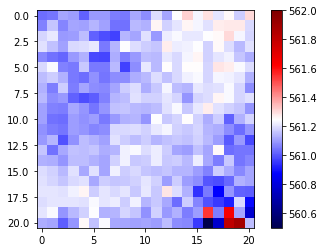

In [12]:
# 全データフィットした結果でヒートマップで表示する
heatmapping(export_df, plotdata, shape_x, shape_z, color_min, color_max, color_type)

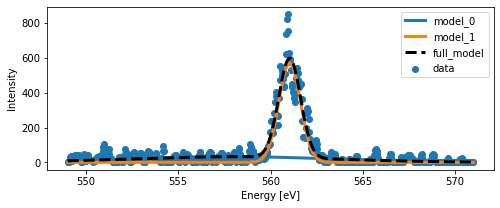

In [13]:
# フィットした結果を再構成してプロット
column_index = 441 # 表示するデータ
plot_reconstracter(df, export_df, 441)